<center><h1> - Tabular Playground Series - Sep 2022 - </h1></center>
<b>Goal</b>: Predicting book sales during the year 2021 for 4 items from two competing stores located in six different countries.

### ⬇ Libraries

In [1]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 181 kB 44.5 MB/s 
     |████████████████████████████████| 158 kB 50.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 36.3 MB/s 
     |████████████████████████████████| 157 kB 46.7 MB/s 
     |████████████████████████████████| 157 kB 49.2 MB/s 
     |████████████████████████████████| 157 kB 48.2 MB/s 
     |████████████████████████████████| 157 kB 59.6 MB/s 
     |████████████████████████████████| 157 kB 34.9 MB/s 
     |████████████████████████████████| 157 kB 34.7 MB/s 
     |████████████████████████████████| 156 kB 35.7 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=119f6e1f22f51c58a4a0a163b954ab7ea1f61daa41f55aa5e4fd6b17a8c6eb0a
  Stored in directory: /root/.cache/pip/wheels/3e/31/

In [12]:
import os
import datetime
import wandb
import scipy
import scipy.optimize

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf

from scipy.fft import fft, fftfreq


### Content
- **EDA**: Insights I got from the data
- **Prepare dataset**: Aggregate data across stores and countries
- **Handle products**: Fitt sine functions to the product ratios
- **Window dataset**: Create windows to train the model on
- **Train**: Evaluate model performance with a set of different architectures (DNN, LSTM)
- **Compare**: Compare result to XGBoostRegressor

### EDA

- 💡 **Main insights**
    - Data after 2020 is different from the years before.
    - Include time dependency as some sort of cosine or sine function
    - The country does not have any influence after 2020.
    - Sales in the two stores differ only by a constant factor.
    - Insight from [TPS2209_Ridge_LGBM_EDA_TopDownApproach](https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach) by [ehekatlact](https://www.kaggle.com/ehekatlact):
        - Proportion of sales is sinusoidal. Therefore it is possible to predict the total number of sales and the proportion of sales by product respectively.

- <b> Things to keep in mind </b>
    - Remove last day in Feb. of leap year

### Wandb
- Login to wandb by `wandb login <secret>`

In [ ]:
def start_wandb_run(name):
    wandb.init(project="kaggle-tps-september-2022", name='tabular_explore')

def end_wandb_run():
    wandb.finish()

### Folders

In [3]:
PROJECT_DIR = os.path.join(".")
DATASET_DIR = os.path.join(PROJECT_DIR, "dataset")

### Load dataset

In [4]:
train_df = pd.read_csv(os.path.join(DATASET_DIR, "train.csv"))
test_df = pd.read_csv(os.path.join(DATASET_DIR, "test.csv"))
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

### Drop Leap year day

In [5]:
print("Before dropping training data shape is: ", train_df.shape)
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df = train_df[train_df.date != pd.Timestamp("2020-02-29")]
train_df
print("After dropping training data shape is: ", train_df.shape)

Before dropping training data shape is:  (70128, 6)
After dropping training data shape is:  (70080, 6)


In [6]:
train_df.head()

row_id       date  country       store                           product  \
0       0 2017-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1       1 2017-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2       2 2017-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3       3 2017-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4       4 2017-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   num_sold  
0       663  
1       615  
2       480  
3       710  
4       240

In [7]:
test_df.head()

row_id       date  country       store                           product
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques

### **EDA**

#### **Basic exploration**
- **Train dataset Columns**:
    - **row_id**: Incrementing row of dataset.
    - **date (timestamp)**: The day on which the book stores are opened beginning from 2017-01-01 up to 2020-12-31. Note that the stores neither close on weekends nor during holidays.
    - **country (str)**: The 6 different countries - Belgium, France, Germany, Italy, Poland & Spain
    - **store (str)**: The 2 competing store names - KaggleMart & KaggleRama
    - **product (str)**: The 4 different book names
    - **num_sold (int)**: Target value - Number of sales for given date.

In [ ]:
start_wandb_run(name='tabular_explore')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: janoliver_seidenfuss. Use `wandb login --relogin` to force relogin


In [ ]:
print(f"Train data shape {train_df.shape} - Test data shape {test_df.shape}")

Train data shape (70080, 6) - Test data shape (17520, 5)


<AxesSubplot:title={'center':'Occurance in test df'}, xlabel='Product'>

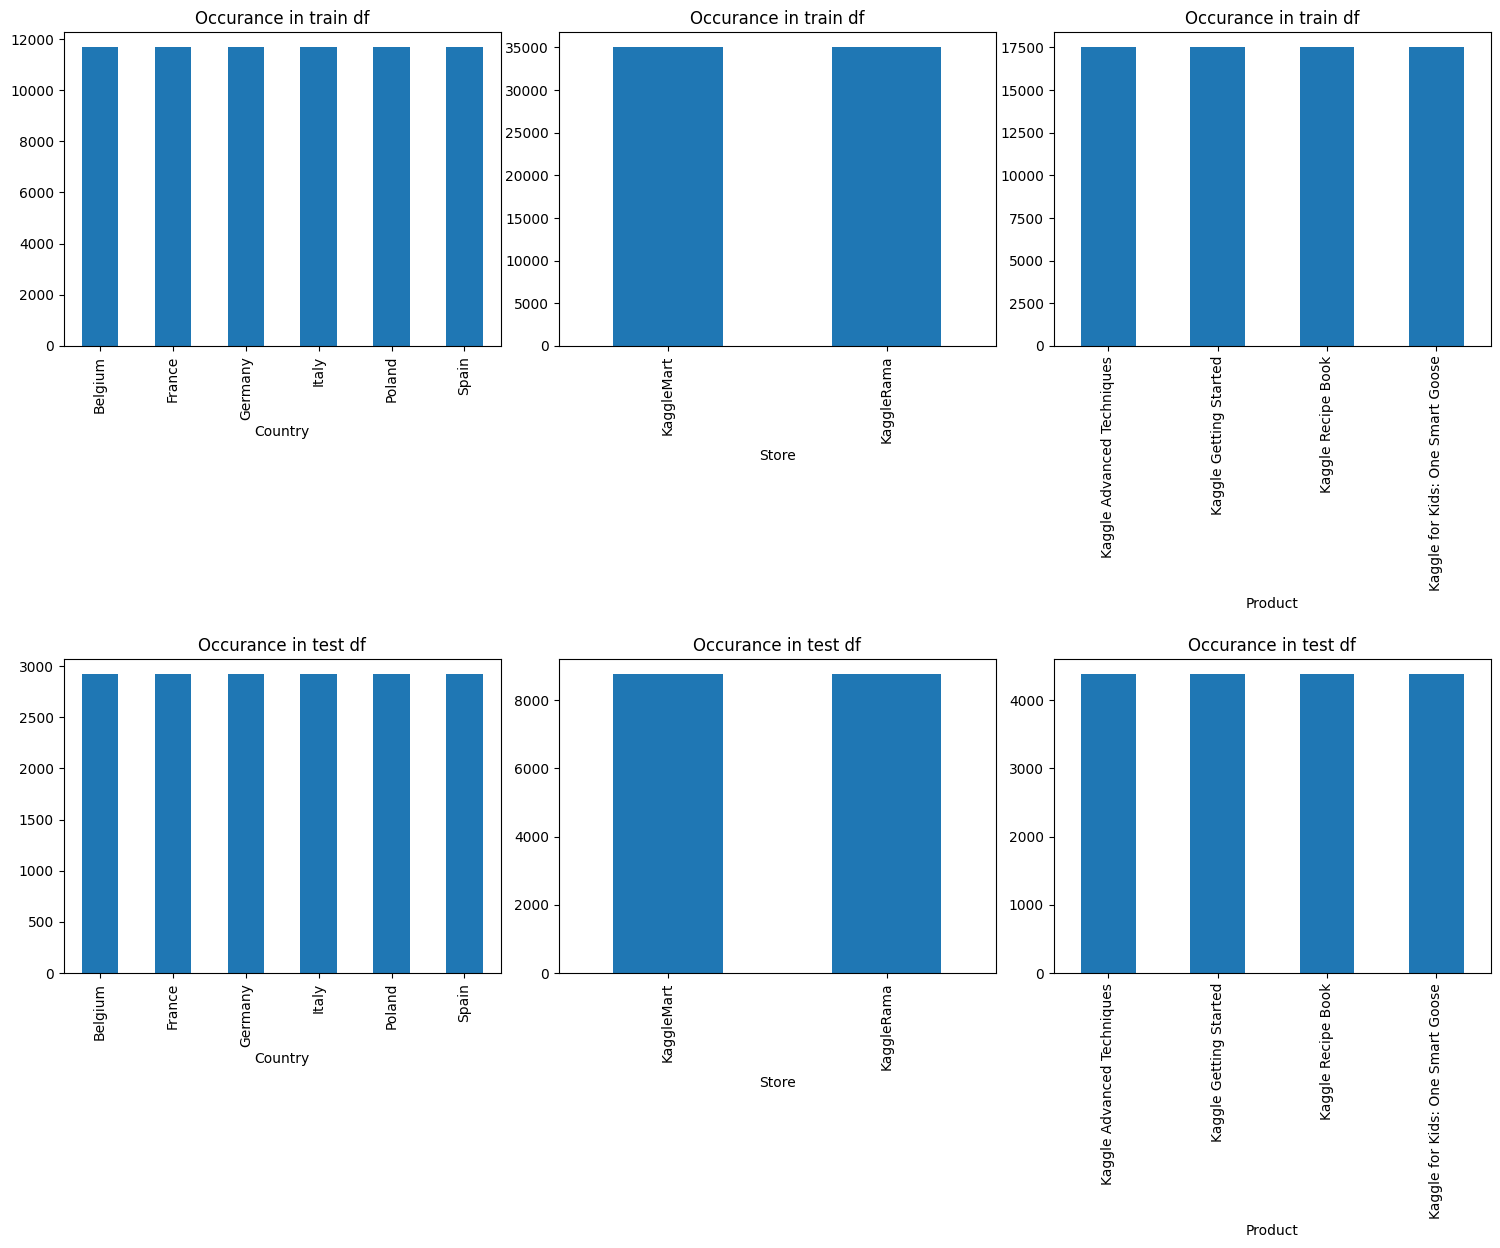

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
fig.tight_layout()
plt.subplots_adjust(hspace=1)
# -> Train dataset
# Plot country occurances
axes[0][0].set_title('Occurance in train df')
axes[0][0].set_xlabel('Country')
train_df.country.value_counts().plot(ax=axes[0][0], kind = 'bar')
# Plot store occurances
axes[0][1].set_title('Occurance in train df')
axes[0][1].set_xlabel('Store')
train_df.store.value_counts().plot(ax=axes[0][1], kind = 'bar')
# Plot product occurances
axes[0][2].set_title('Occurance in train df')
axes[0][2].set_xlabel('Product')
train_df['product'].value_counts().plot(ax=axes[0][2], kind = 'bar')
# -> Test dataset
# Plot country occurances
axes[1][0].set_title('Occurance in test df')
axes[1][0].set_xlabel('Country')
test_df.country.value_counts().plot(ax=axes[1][0], kind = 'bar')
# Plot store occurances
axes[1][1].set_title('Occurance in test df')
axes[1][1].set_xlabel('Store')
test_df.store.value_counts().plot(ax=axes[1][1], kind = 'bar')
# Plot product occurances
axes[1][2].set_title('Occurance in test df')
axes[1][2].set_xlabel('Product')
test_df['product'].value_counts().plot(ax=axes[1][2], kind = 'bar')
wandb.log({"feature_distribution": fig})

In [ ]:
wandb.log({"feature_distribution": fig})
end_wandb_run()

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:647: UserWarning:

Looks like the annotation(s) you are trying 
to draw lies/lay outside the given figure size.

Therefore, the resulting Plotly figure may not be 
large enough to view the full text. To adjust 
the size of the figure, use the 'width' and 
'height' keys in the Layout object. Alternatively,
use the Margin object to adjust the figure's margins.



- **❗ Insights**
    - The dataset is perfectly structured and covers 4 years worth of training and 1 year worth of testing data
    - No missing data
    - Each day contains the `num_sold` for 2 shops across 6 countries & 4 different items

#### **Further analysis of**
- Sales per country
- Sales per country & individual product
- Sales per store
- Sales per store & individual product
- Sales per store & country

In [ ]:
# Convert column types
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

#### **Sales per Country**

In [ ]:
start_wandb_run(name='sales_per_country_explore')

In [ ]:
sales_per_country = train_df.groupby(['date','country']).agg({
    'num_sold': 'sum',
}).reset_index()
sales_per_country = sales_per_country.set_index('date')

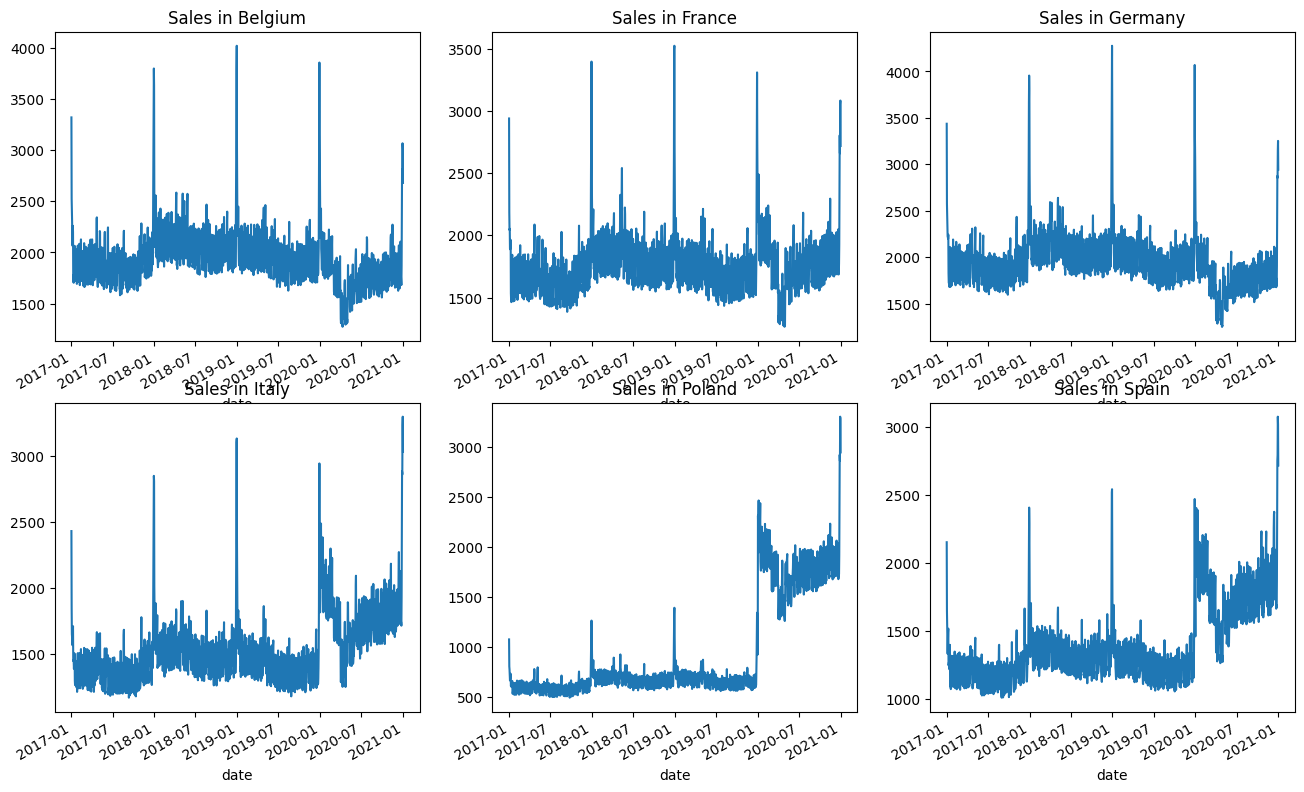

In [ ]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,10))
axes[0][0].set_title('Sales in Belgium')
axes[0][0].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'Belgium']['num_sold'].plot(ax=axes[0][0])
axes[0][1].set_title('Sales in France')
axes[0][1].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'France']['num_sold'].plot(ax=axes[0][1])
axes[0][2].set_title('Sales in Germany')
axes[0][2].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'Germany']['num_sold'].plot(ax=axes[0][2])
axes[1][0].set_title('Sales in Italy')
axes[1][0].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'Italy']['num_sold'].plot(ax=axes[1][0])
axes[1][1].set_title('Sales in Poland')
axes[1][1].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'Poland']['num_sold'].plot(ax=axes[1][1])
axes[1][2].set_title('Sales in Spain')
axes[1][2].set_xlabel('dates')
sales_per_country[sales_per_country['country'] == 'Spain']['num_sold'].plot(ax=axes[1][2])
plt.show()
wandb.log({"sales_per_country": fig})

In [ ]:
def plot_sales_per_country(df):
    fig = plt.figure(figsize=(14, 10), dpi=150)
    df[df['country'] == 'Belgium']['num_sold'].plot(label='Belgium')
    df[df['country'] == 'France']['num_sold'].plot(label='France')
    df[df['country'] == 'Germany']['num_sold'].plot(label='Germany')
    df[df['country'] == 'Italy']['num_sold'].plot(label='Italy')
    df[df['country'] == 'Poland']['num_sold'].plot(label='Poland')
    df[df['country'] == 'Spain']['num_sold'].plot(label='Spain')
    plt.legend()
    plt.title("Sales per country")
    plt.xlabel("date")
    plt.show()
    return fig

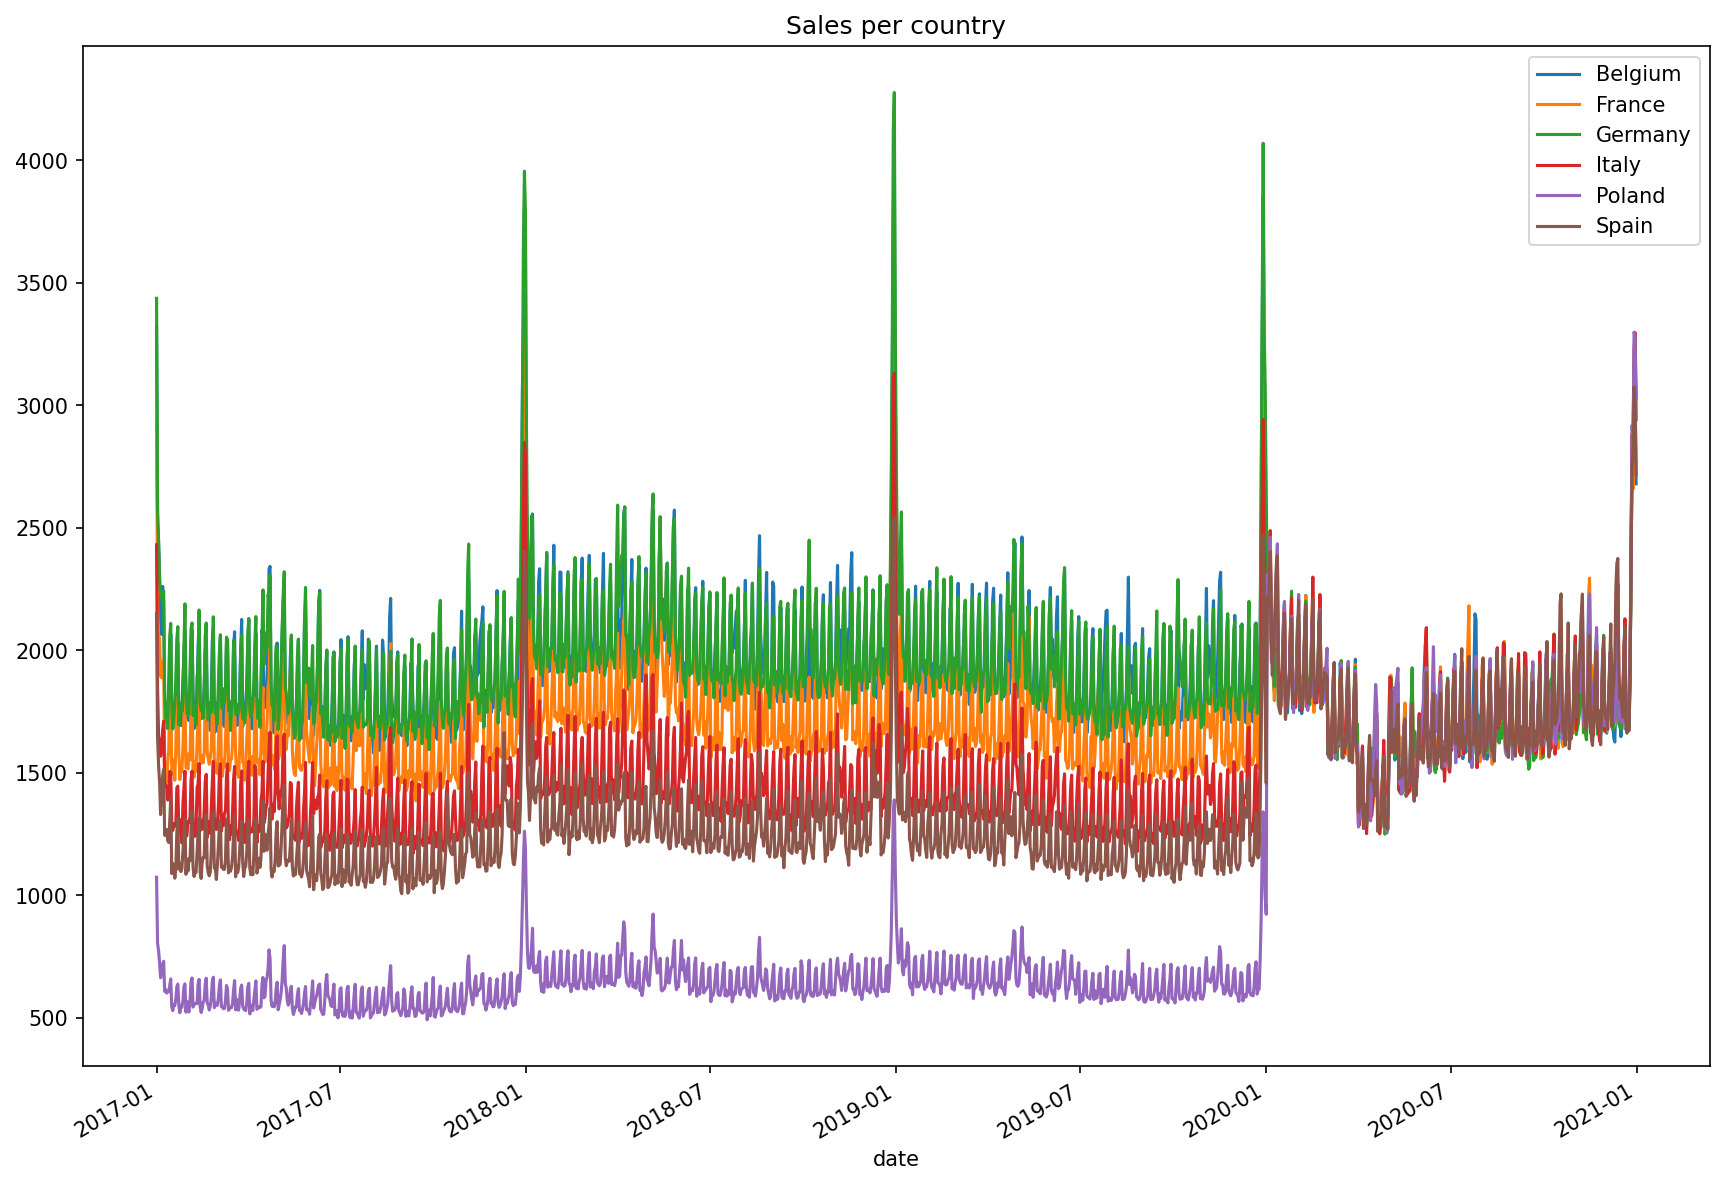

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
fig = plot_sales_per_country(sales_per_country)
wandb.log({"sales_per_country_combined": fig})

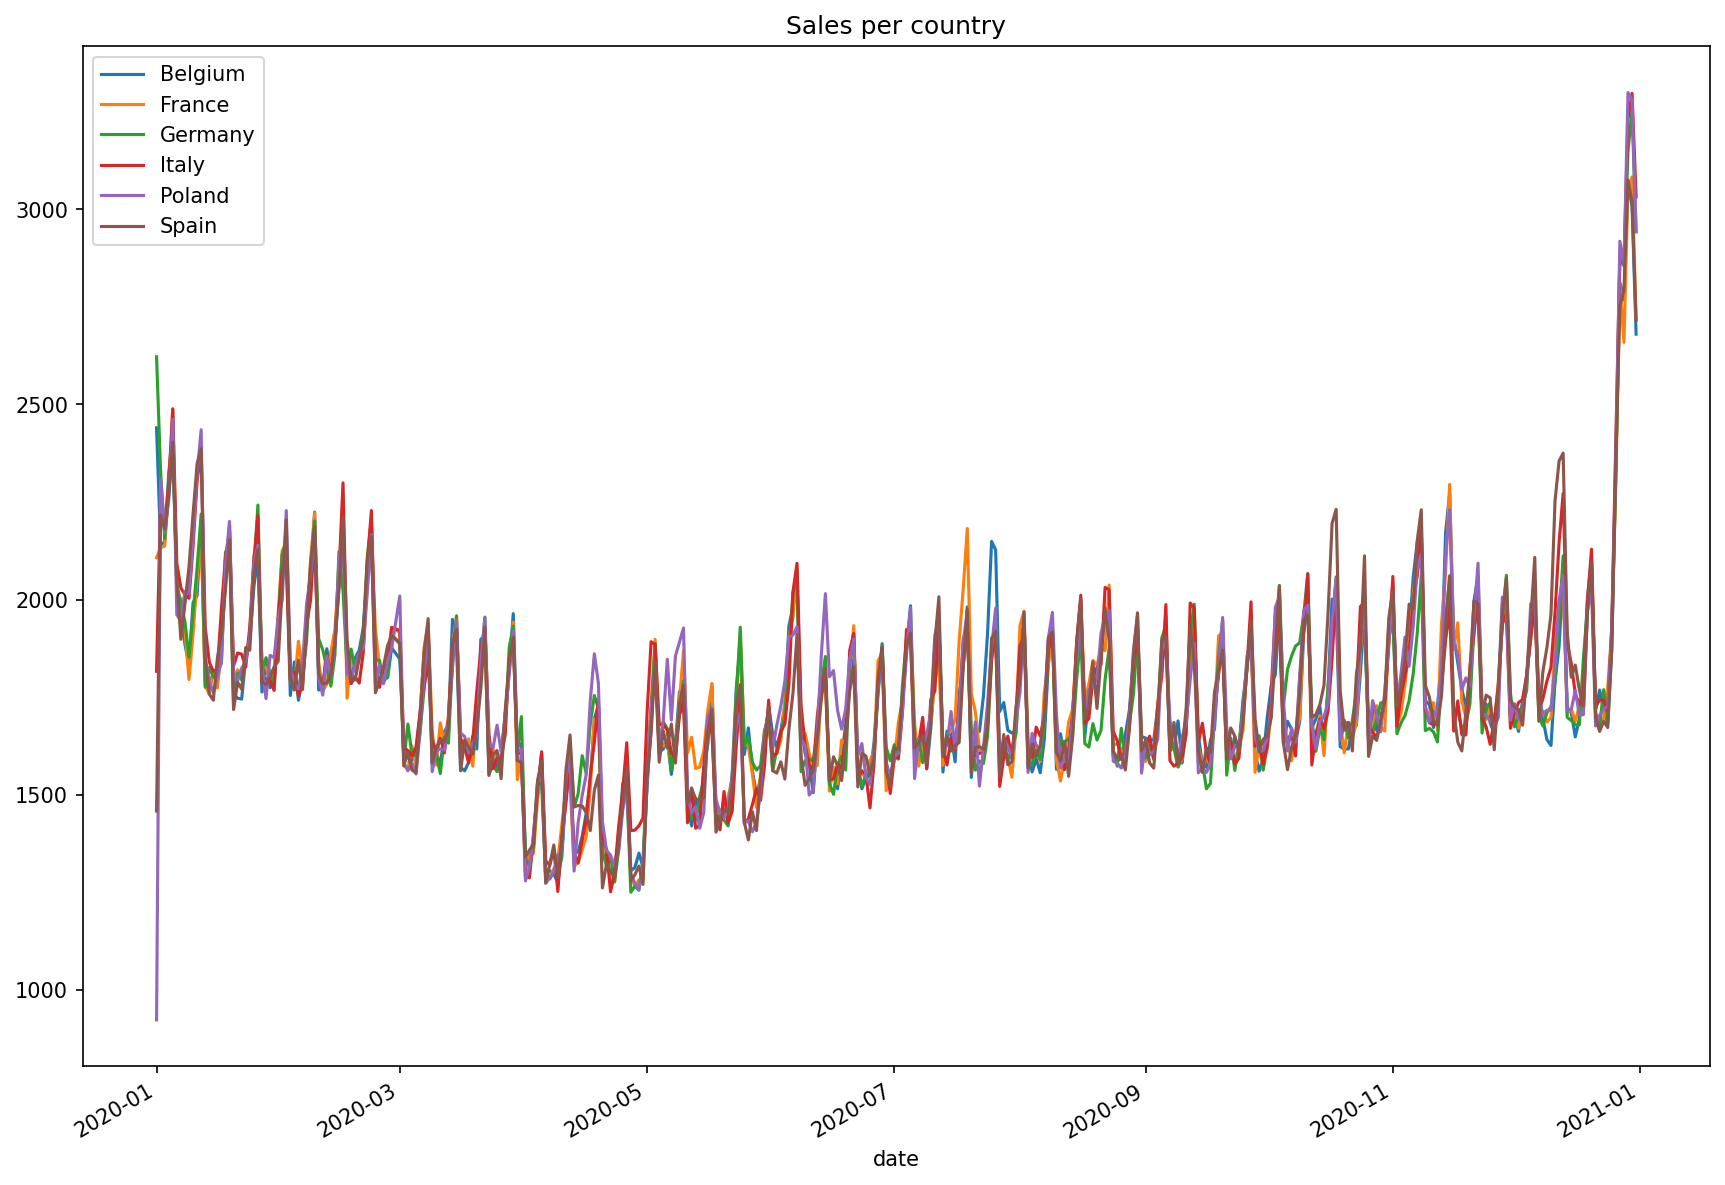

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
fig = plot_sales_per_country(sales_per_country[sales_per_country.index >= pd.Timestamp("2020-01-01")])
wandb.log({"sales_per_country_2020": fig})

In [ ]:
end_wandb_run()

- ❗ **Insights**:
    - Change in data from year 2020 onward: Across all 6 countries the sales are almost identical in terms of absolute value and seasonality.
    - Spikes at the end of each year -> Seasonality
    - Weekly seasonality

#### **Sales per Country & products**

In [ ]:
start_wandb_run(name='sales_per_country_and_product_explore')

In [ ]:
product_sales_per_country = train_df.groupby(['date','country', 'product']).agg({
    'num_sold': 'sum',
}).reset_index()

# Fuse the two columns country & product
product_sales_per_country["product_by_country"] = product_sales_per_country["country"] + " - " + product_sales_per_country["product"]
product_sales_per_country.drop(["country", "product"], axis=1, inplace=True)

product_sales_per_country = product_sales_per_country.set_index('date')
# Get all product names
products = train_df["product"].unique()

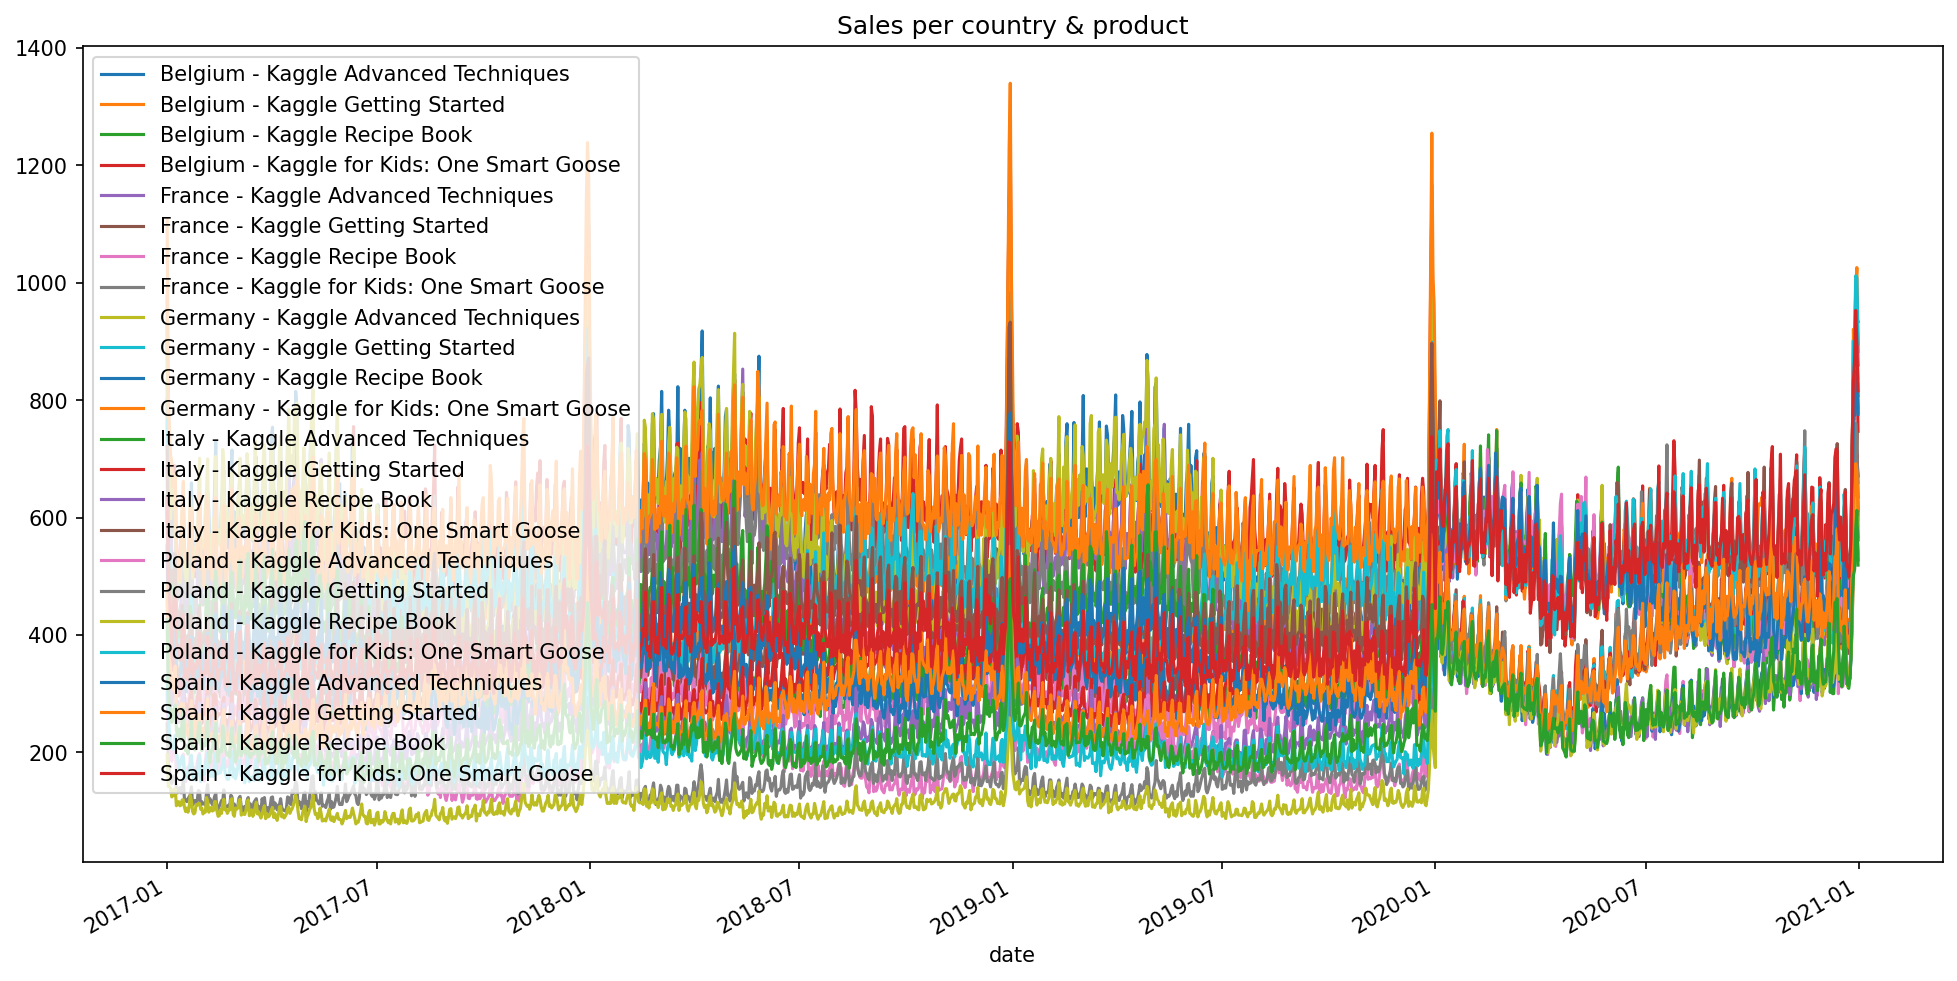

In [ ]:
# All books in one plot where books have same color
plt.figure(figsize=(16, 8), dpi=150)
for product_country_combination in product_sales_per_country.product_by_country.unique():
    product_sales_per_country[product_sales_per_country['product_by_country'] == product_country_combination]['num_sold'].plot(label=product_country_combination)
plt.legend()
plt.title("Sales per country & product")
plt.xlabel("date")
plt.show()

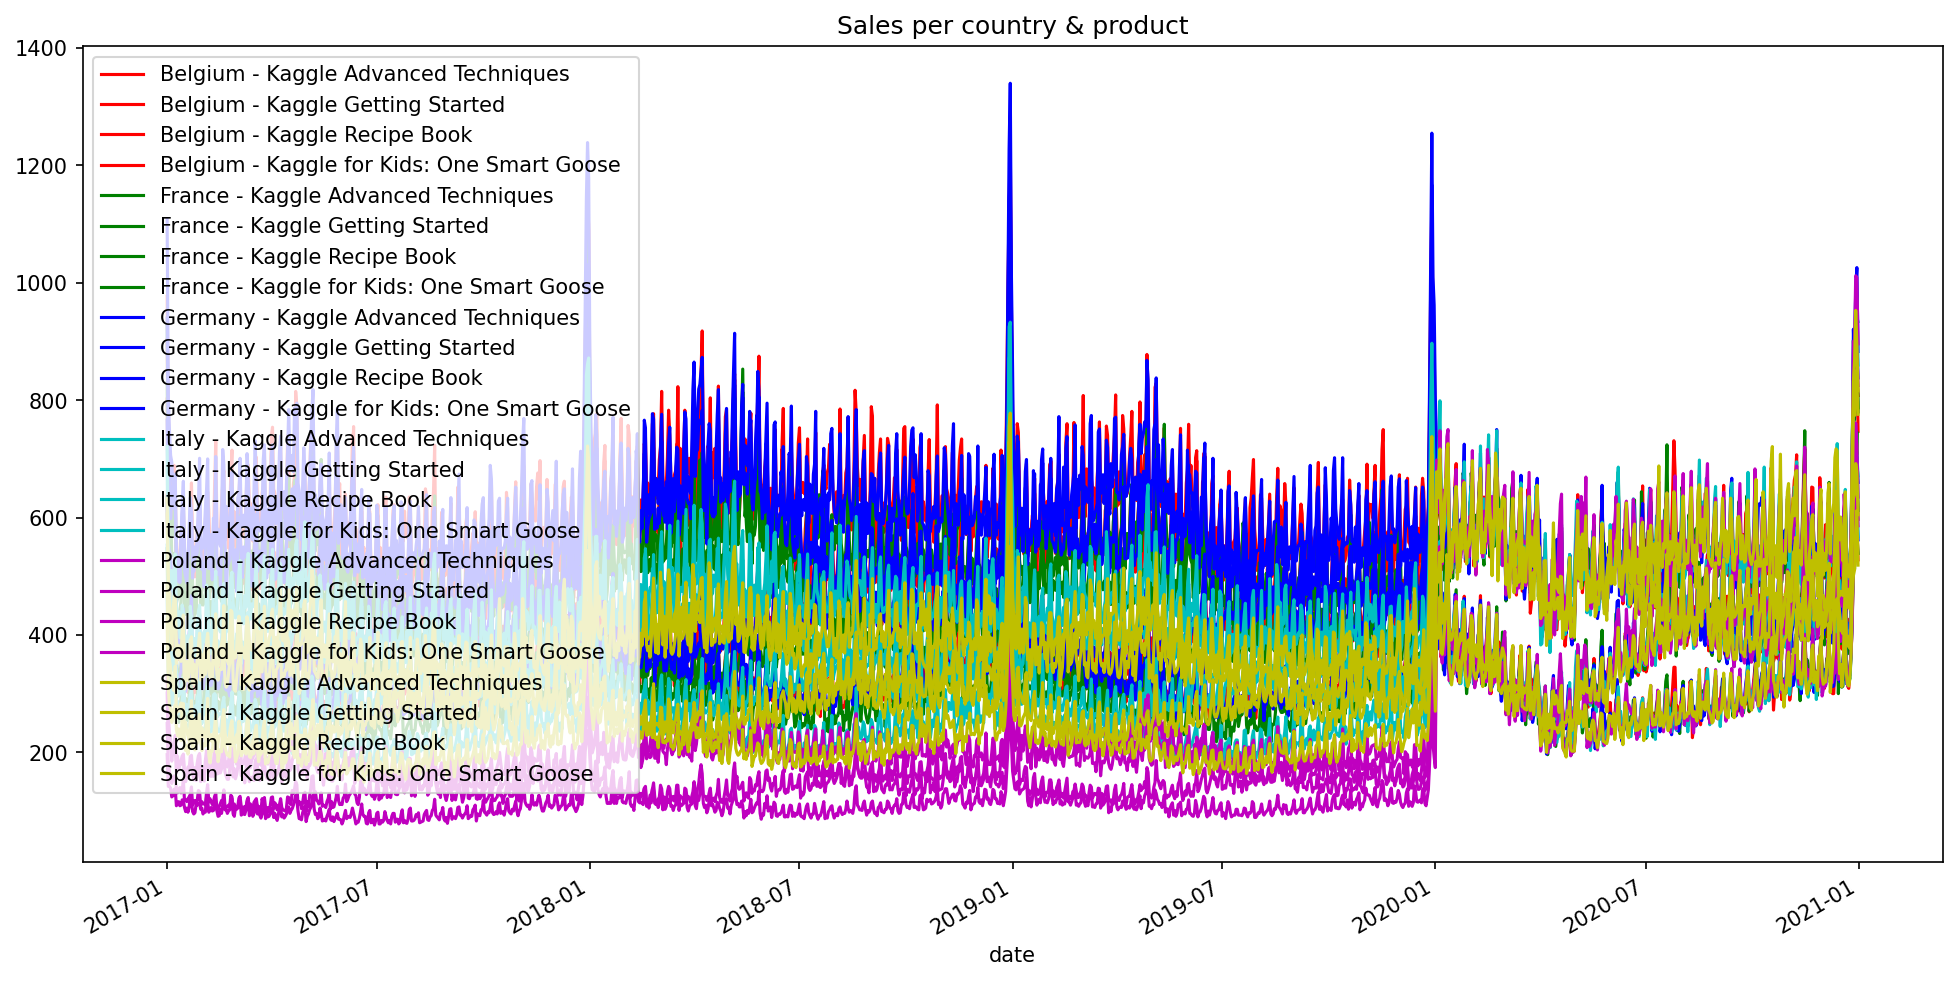

In [ ]:
# Color countries the same
country_to_color = {}
countries = train_df.country.unique()
colors = ["r", "g", "b", "c", "m", "y"]
for idx, country in enumerate(countries):
    country_to_color[country] = colors[idx]

plt.figure(figsize=(16, 8), dpi=150)
for product_country_combination in product_sales_per_country.product_by_country.unique():
    product_sales_per_country[product_sales_per_country['product_by_country'] == product_country_combination]['num_sold'].plot(label=product_country_combination, c = country_to_color[product_country_combination.split(" - ")[0]])
plt.legend()
plt.title("Sales per country & product")
plt.xlabel("date")
plt.show()

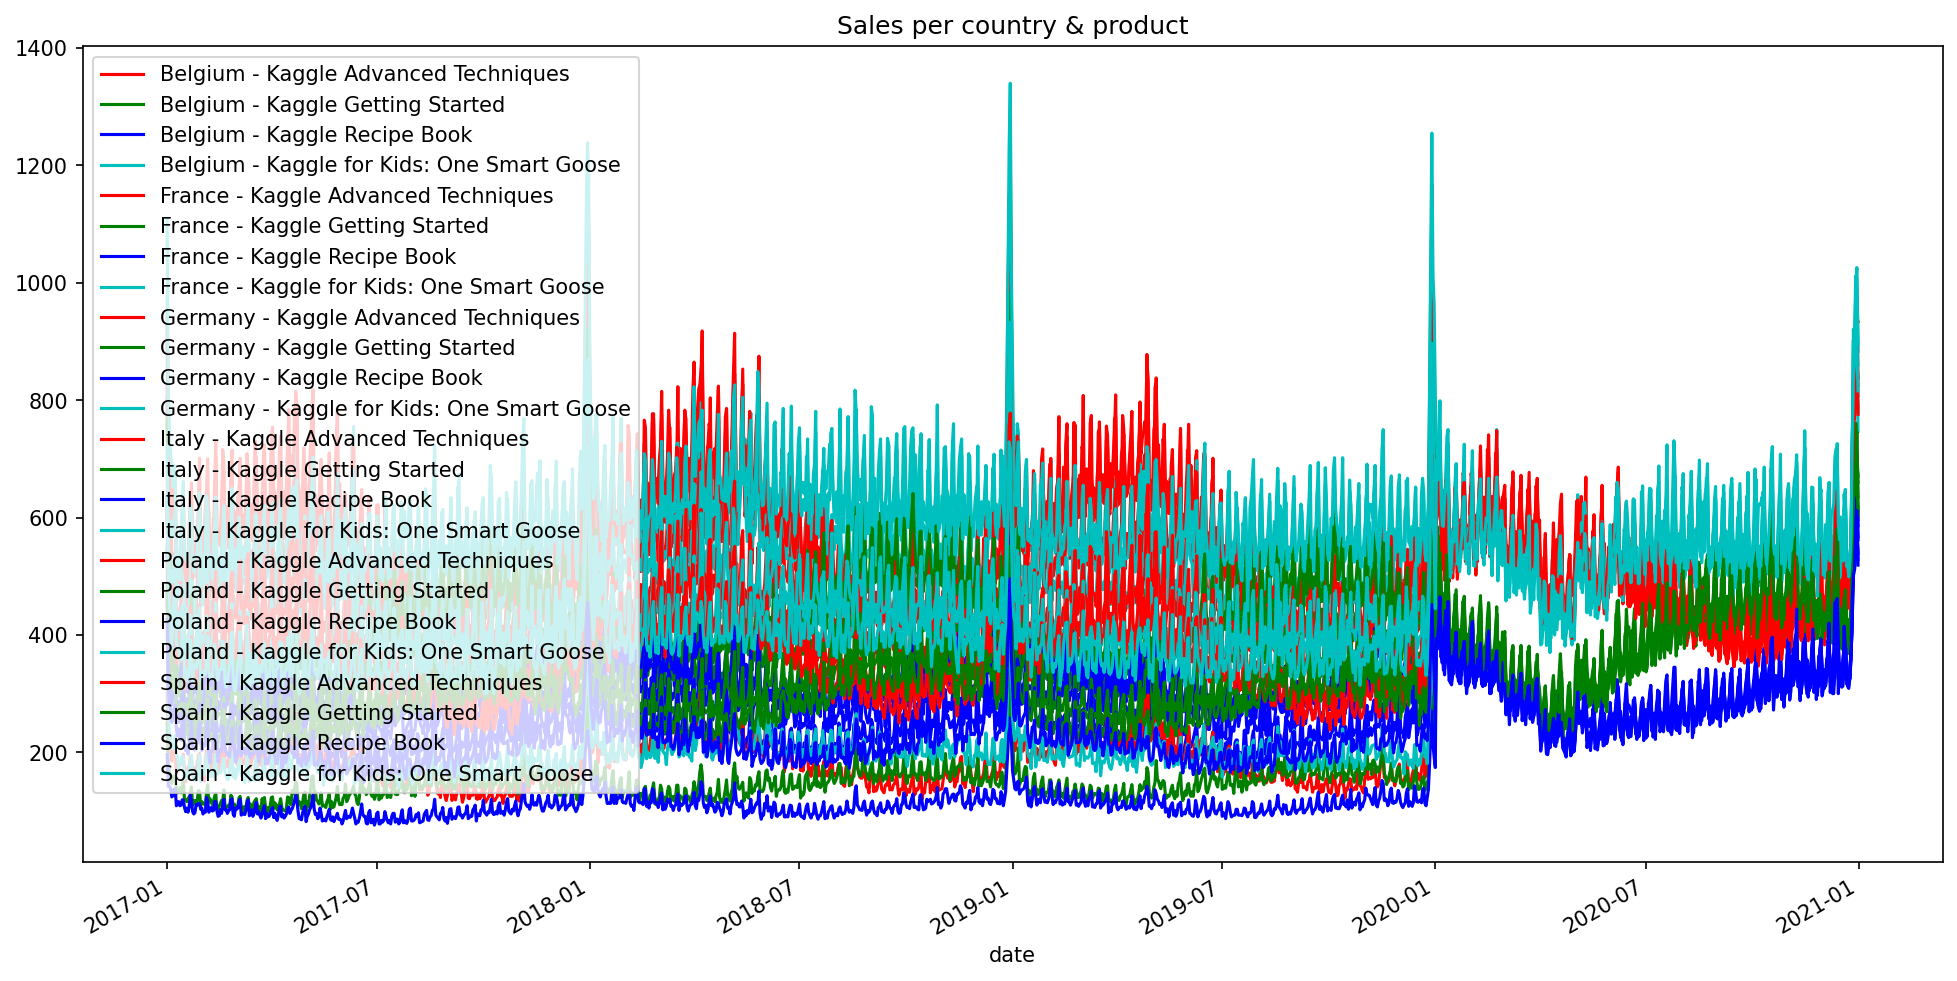

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Color products the same
product_to_color = {}
countries = train_df["product"].unique()
colors = ["r", "g", "b", "c", "m", "y"]
for idx, product in enumerate(countries):
    product_to_color[product] = colors[idx]

fig = plt.figure(figsize=(16, 8), dpi=150)
for product_country_combination in product_sales_per_country.product_by_country.unique():
    product_sales_per_country[product_sales_per_country['product_by_country'] == product_country_combination]['num_sold'].plot(label=product_country_combination, c = product_to_color[product_country_combination.split(" - ")[1]])
plt.legend()
plt.title("Sales per country & product")
plt.xlabel("date")
plt.show()
wandb.log({"sales_per_country_by_product": fig})

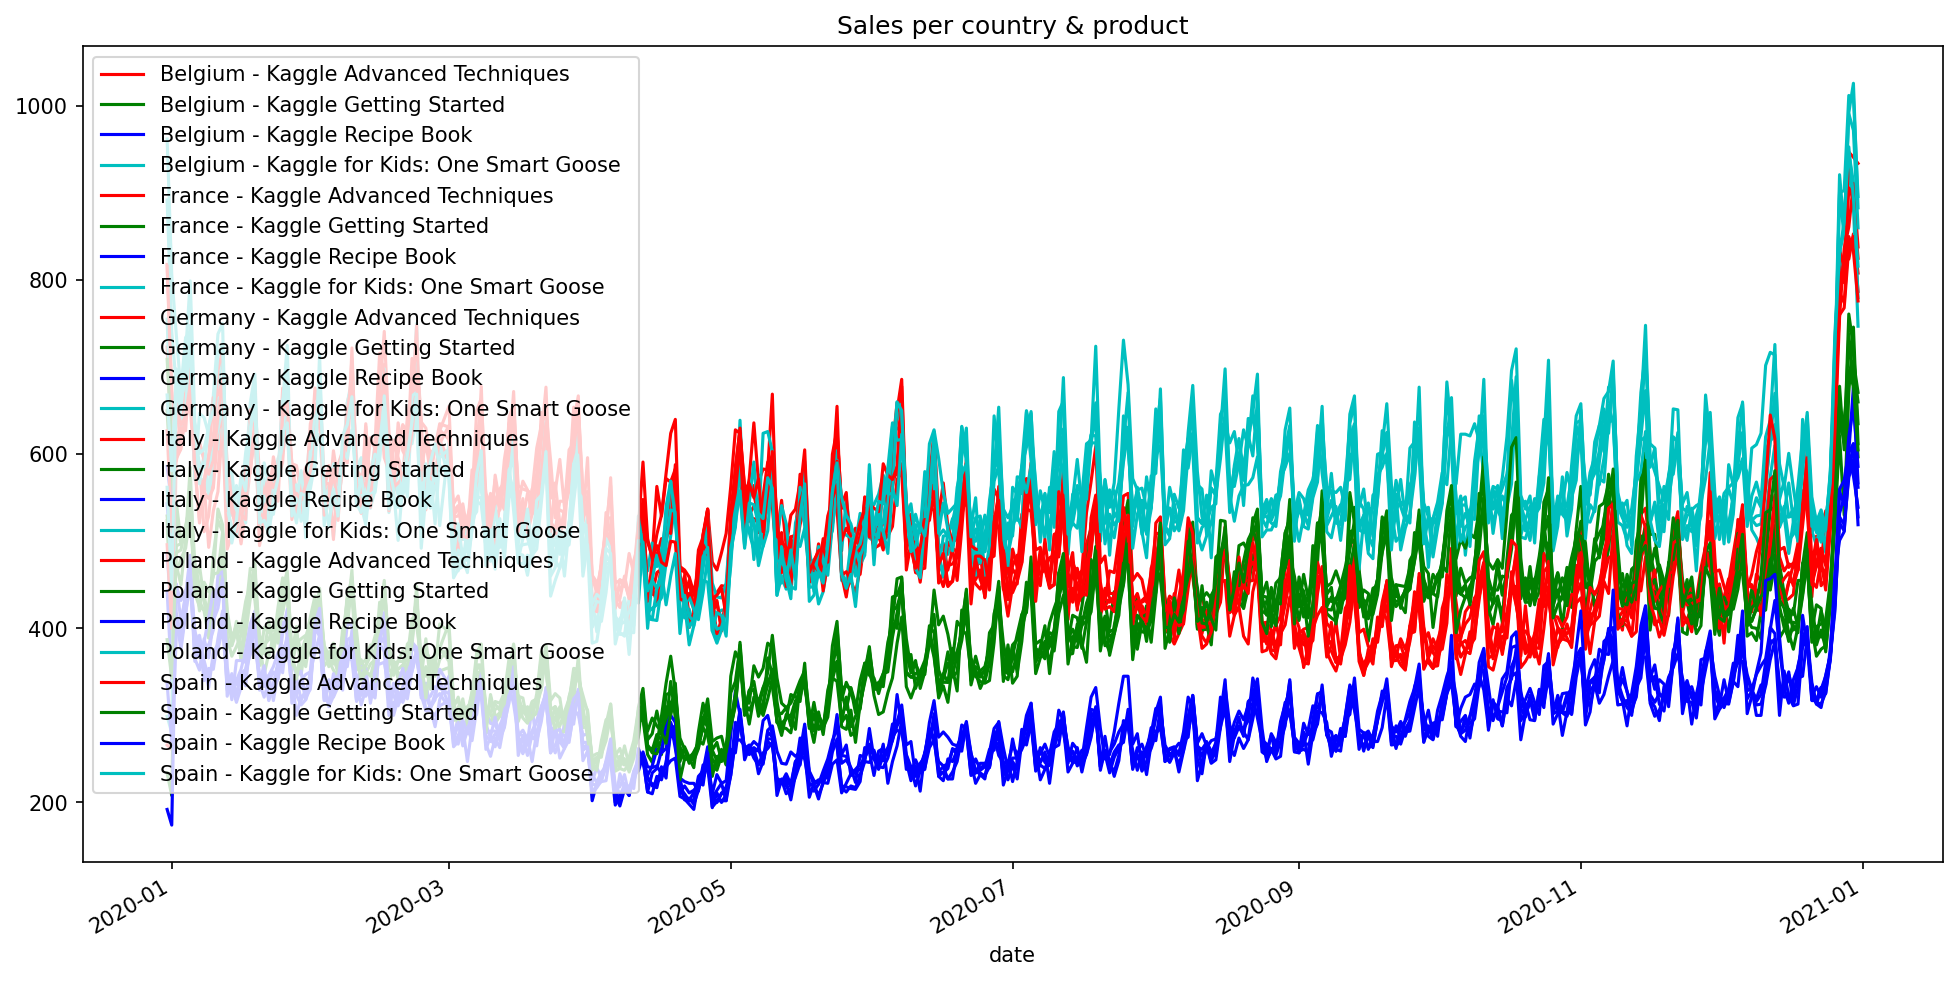

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
# Zoom in on 2020
product_sales_per_country.reset_index(inplace=True)
product_sales_per_country_2020 = product_sales_per_country[product_sales_per_country["date"] > pd.Timestamp("2019-12-30")]
product_sales_per_country_2020.set_index('date', inplace=True)

fig = plt.figure(figsize=(16, 8), dpi=150)
for product_country_combination in product_sales_per_country_2020.product_by_country.unique():
    product_sales_per_country_2020[product_sales_per_country_2020['product_by_country'] == product_country_combination]['num_sold'].plot(label=product_country_combination, c = product_to_color[product_country_combination.split(" - ")[1]])
plt.legend()
plt.title("Sales per country & product")
plt.xlabel("date")
plt.show()
wandb.log({"sales_per_country_by_product_2020": fig})

In [ ]:
end_wandb_run()

#### **Sales store**

In [ ]:
start_wandb_run(name='sales_per_store_explore')

In [ ]:
sales_per_store = train_df.groupby(['date','store']).agg({
    'num_sold': 'sum',
}).reset_index()
sales_per_store = sales_per_store.set_index('date')

def plot_sales_per_store(df):
    fig = plt.figure(figsize=(16, 8), dpi=150)
    df[df['store'] == 'KaggleMart']['num_sold'].plot(label='KaggleMart')
    df[df['store'] == 'KaggleRama']['num_sold'].plot(label='KaggleRama')
    plt.legend()
    plt.title("Sales per store")
    plt.xlabel("date")
    plt.show()
    return fig

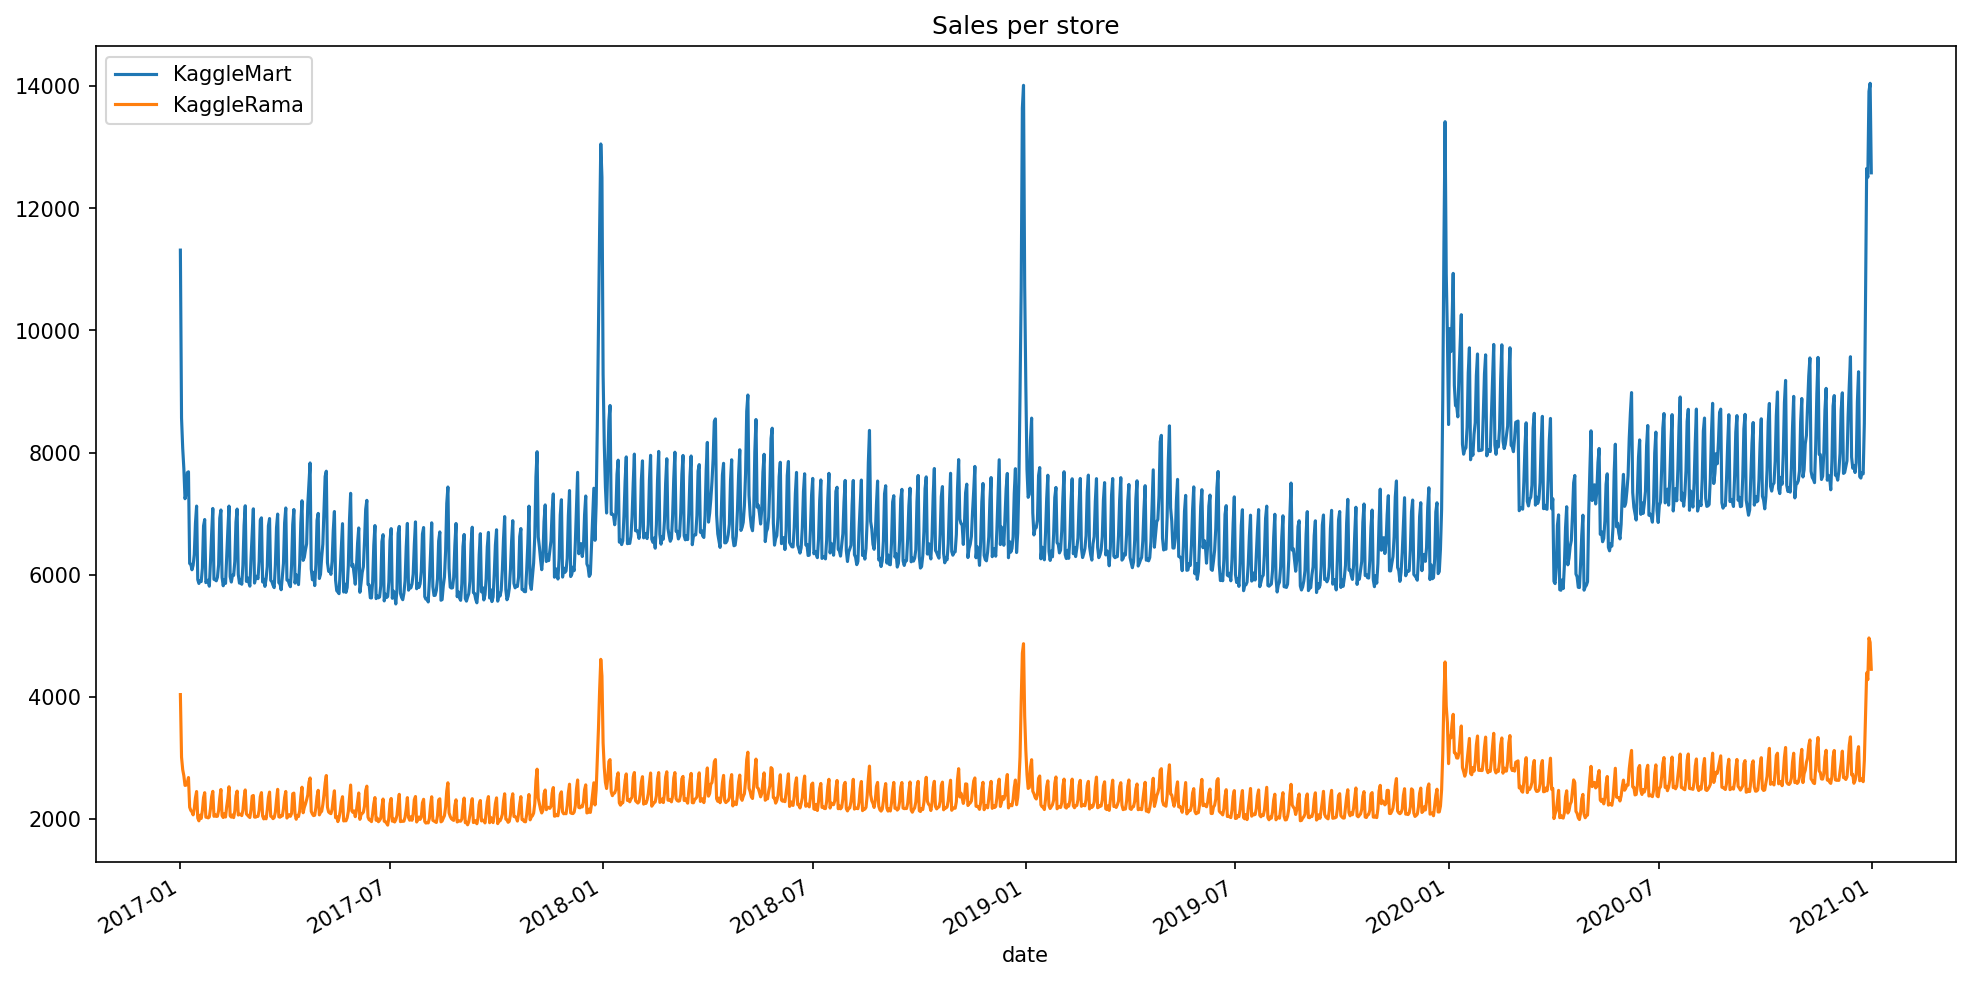

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
fig = plot_sales_per_store(sales_per_store)
wandb.log({"sales_per_store": fig})

**Correlation between time series**

In [ ]:
inter_store_correlation = sales_per_store[sales_per_store['store'] == 'KaggleMart']['num_sold'].corr(sales_per_store[sales_per_store['store'] == 'KaggleRama']['num_sold'])
print(f"Inter store correlation is {inter_store_correlation}")
wandb.log({"time series inter-store-correlation": inter_store_correlation})

Inter store correlation is 0.9950190470604469


In [ ]:
mean_div_coeff = (sales_per_store[sales_per_store['store'] == 'KaggleMart']['num_sold'] / sales_per_store[sales_per_store['store'] == 'KaggleRama']['num_sold']).mean()
std_div_coeff = (sales_per_store[sales_per_store['store'] == 'KaggleMart']['num_sold'] / sales_per_store[sales_per_store['store'] == 'KaggleRama']['num_sold']).std()
print(f"Mean division coeff = {mean_div_coeff} and std = {std_div_coeff} across time.")
wandb.log({"multiplication_coeff_mean": mean_div_coeff})
wandb.log({"multiplication_coeff_std": std_div_coeff})

Mean division coeff = 2.88427522834516 and std = 0.04375933679981326 across time.


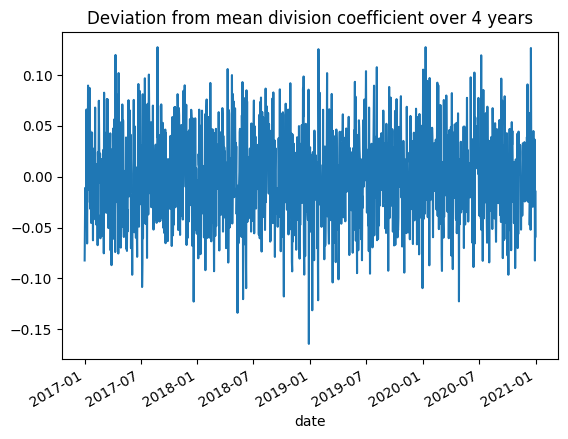

In [ ]:
dev_plot = ((sales_per_store[sales_per_store['store'] == 'KaggleMart']['num_sold'] / sales_per_store[sales_per_store['store'] == 'KaggleRama']['num_sold']) - mean_div_coeff).plot()
dev_plot.set_title("Deviation from mean division coefficient over 4 years")
plt.show()
wandb.log({"timeseries_residual_after_multiplication": dev_plot})

In [ ]:
# From total sales
store_weights = train_df.groupby("store")["num_sold"].sum()/train_df["num_sold"].sum()
store_weights

store
KaggleMart    0.742514
KaggleRama    0.257486
Name: num_sold, dtype: float64

In [ ]:
end_wandb_run()

- **❗ Insights**:
    - The two shops are almost perfectly correlated even in 2020. Given one book store we should be able to predict the other one by a simple multiplication and some noise.

#### **Sales per store & products**

In [ ]:
start_wandb_run(name='sales_per_store_and_product_explore')

In [ ]:
product_sales_per_store = train_df.groupby(['date','store','product']).agg({
    'num_sold': 'sum',
}).reset_index()
product_sales_per_store = product_sales_per_store.set_index('date')
# Fuse the two columns
product_sales_per_store["product_by_store"] = product_sales_per_store["store"] + " - " + product_sales_per_store["product"]
product_sales_per_store.drop(["store", "product"], axis=1, inplace=True)

# All books in one plot where books have same color
def plot_product_sales_per_store(df):
    fig = plt.figure(figsize=(16, 8), dpi=150)
    df[df['product_by_store'] == 'KaggleMart - Kaggle Advanced Techniques']['num_sold'].plot(label='KaggleMart - Kaggle Advanced Techniques', c="r")
    df[df['product_by_store'] == 'KaggleMart - Kaggle Getting Started']['num_sold'].plot(label='KaggleMart - Kaggle Getting Started', c="b")
    df[df['product_by_store'] == 'KaggleMart - Kaggle Recipe Book']['num_sold'].plot(label='KaggleMart - Kaggle Recipe Book', c="g")
    df[df['product_by_store'] == 'KaggleMart - Kaggle for Kids: One Smart Goose']['num_sold'].plot(label='KaggleMart - Kaggle for Kids: One Smart Goose', c="orange")
    df[df['product_by_store'] == 'KaggleRama - Kaggle Advanced Techniques']['num_sold'].plot(label='KaggleRama - Kaggle Advanced Techniques', c="r")
    df[df['product_by_store'] == 'KaggleRama - Kaggle Getting Started']['num_sold'].plot(label='KaggleRama - Kaggle Getting Started', c="b")
    df[df['product_by_store'] == 'KaggleRama - Kaggle Recipe Book']['num_sold'].plot(label='KaggleRama - Kaggle Recipe Book', c="g")
    df[df['product_by_store'] == 'KaggleRama - Kaggle for Kids: One Smart Goose']['num_sold'].plot(label='KaggleRama - Kaggle for Kids: One Smart Goose', c="orange")

    plt.legend()
    plt.title("Sales per store & books")
    plt.xlabel("date")
    plt.show()
    return fig

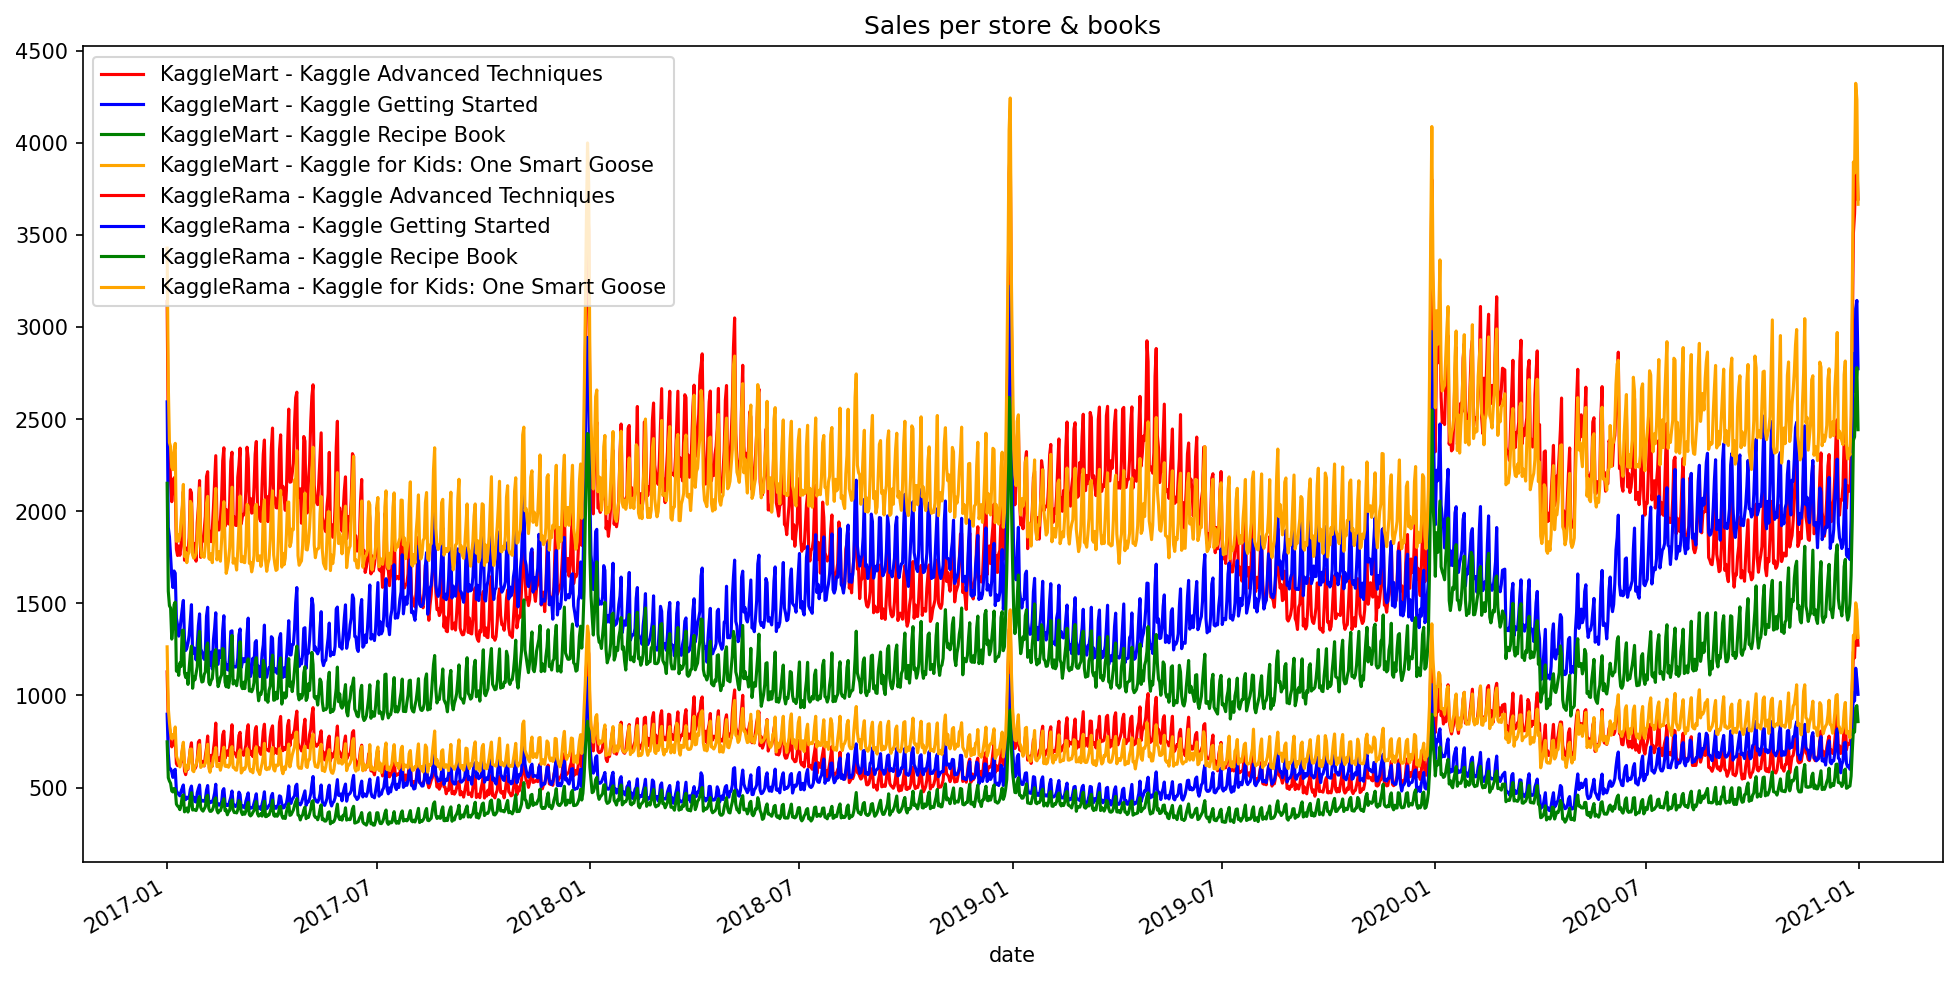

/Users/janoliverseidenfuss/Documents/privat/Kaggle/venv/lib/python3.9/site-packages/plotly/matplotlylib/renderer.py:611: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [ ]:
fig = plot_product_sales_per_store(product_sales_per_store)
wandb.log({"sales_per_store_by_book": fig})

**Correlation across shops of same product**

In [ ]:
def calc_corr_and_const_factor(df):
    mart_book1 = df[df['product_by_store'] == 'KaggleMart - Kaggle Advanced Techniques']['num_sold']
    mart_book2 = df[df['product_by_store'] == 'KaggleMart - Kaggle Getting Started']['num_sold']
    mart_book3 = df[df['product_by_store'] == 'KaggleMart - Kaggle Recipe Book']['num_sold']
    mart_book4 = df[df['product_by_store'] == 'KaggleMart - Kaggle for Kids: One Smart Goose']['num_sold']
    rama_book1 = df[df['product_by_store'] == 'KaggleRama - Kaggle Advanced Techniques']['num_sold']
    rama_book2 = df[df['product_by_store'] == 'KaggleRama - Kaggle Getting Started']['num_sold']
    rama_book3 = df[df['product_by_store'] == 'KaggleRama - Kaggle Recipe Book']['num_sold']
    rama_book4 = df[df['product_by_store'] == 'KaggleRama - Kaggle for Kids: One Smart Goose']['num_sold']
    print(f"Corr for book 1 between two stores: {mart_book1.corr(rama_book1)}")
    print(f"Corr for book 2 between two stores: {mart_book2.corr(rama_book2)}")
    print(f"Corr for book 3 between two stores: {mart_book3.corr(rama_book3)}")
    print(f"Corr for book 4 between two stores: {mart_book4.corr(rama_book4)}")
    print(f"Constant factor for book 1 sales between the two stores: {(mart_book1 / rama_book1).mean()}")
    print(f"Constant factor for book 2 sales between the two stores: {(mart_book2 / rama_book2).mean()}")
    print(f"Constant factor for book 3 sales between the two stores: {(mart_book3 / rama_book3).mean()}")
    print(f"Constant factor for book 4 sales between the two stores: {(mart_book4 / rama_book4).mean()}")

In [ ]:
# All years
calc_corr_and_const_factor(product_sales_per_store)

Corr for book 1 between two stores: 0.9885372710592121
Corr for book 2 between two stores: 0.9868276923657857
Corr for book 3 between two stores: 0.9867145532339914
Corr for book 4 between two stores: 0.9831233275331626
Constant factor for book 1 sales between the two stores: 2.884497114280004
Constant factor for book 2 sales between the two stores: 2.8854513982209027
Constant factor for book 3 sales between the two stores: 2.889605343639837
Constant factor for book 4 sales between the two stores: 2.8840920951115736


In [ ]:
# 2020 only
calc_corr_and_const_factor(product_sales_per_store[product_sales_per_store.index >= pd.Timestamp("2020-01-01")])

Corr for book 1 between two stores: 0.9848597976857549
Corr for book 2 between two stores: 0.9882153406440968
Corr for book 3 between two stores: 0.9892547636115877
Corr for book 4 between two stores: 0.9757355552093742
Constant factor for book 1 sales between the two stores: 2.890318231912288
Constant factor for book 2 sales between the two stores: 2.8859158788823502
Constant factor for book 3 sales between the two stores: 2.887502845096729
Constant factor for book 4 sales between the two stores: 2.8833798226513396


In [ ]:
end_wandb_run()

**💡Summing up so far**
- **Change in data**: The data changes distribution and behaviour after the year 2020. The years leading up to 2020 aren't representative and might be confusing rather than helpful for the model.
- **Ignore Country**: Before 2020 every country has a different selling behavior. After 2020 these differences disappear. The products sell almost identically across all countries for that time period. We can therefore ignore the country as a feature.
- **Combine Shops**: The influence of shops does not seem to be important, only the product really matters. This can be seen by the high correlation between the same book beeing sold in different stores. There exists a constant factor between the two shops which is 2.88 for all 4 products! Therefore, by only focusing on one shop it could be possible to infer the other one.


#### **Insights from Kaggle for products**

In [ ]:
start_wandb_run(name='product_explore')

In [8]:
product_df = train_df.groupby(["date","product"])["num_sold"].sum().reset_index()

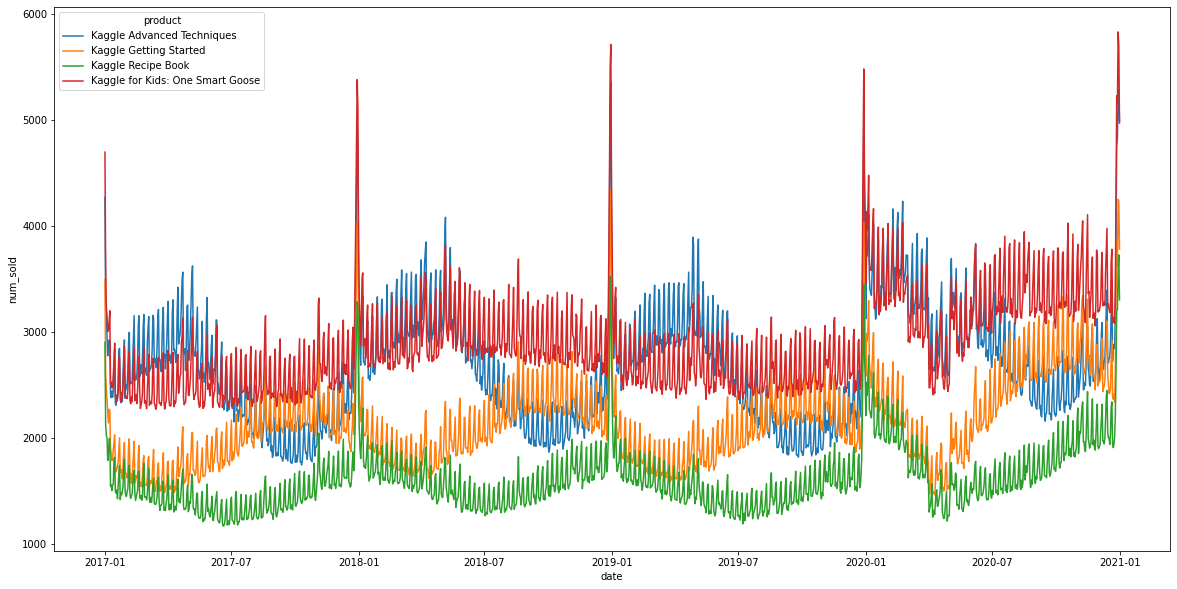

In [10]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data=product_df, x="date", y="num_sold", hue="product");
wandb.log({"sum_sales_per_product": wandb.Image(f)})

**Product ratios**: Looking at the plot one might notice that the overall ratios of total sales per day seem to stay constant even after 2020

In [11]:
product_ratio_df = product_df.pivot(index="date", columns="product", values="num_sold")
product_ratio_df = product_ratio_df.apply(lambda x: x/x.sum(),axis=1)
product_ratio_df = product_ratio_df.stack().rename("ratios").reset_index()
product_ratio_df.head(4)

date                           product    ratios
0 2017-01-01        Kaggle Advanced Techniques  0.277944
1 2017-01-01            Kaggle Getting Started  0.227462
2 2017-01-01                Kaggle Recipe Book  0.188900
3 2017-01-01  Kaggle for Kids: One Smart Goose  0.305693

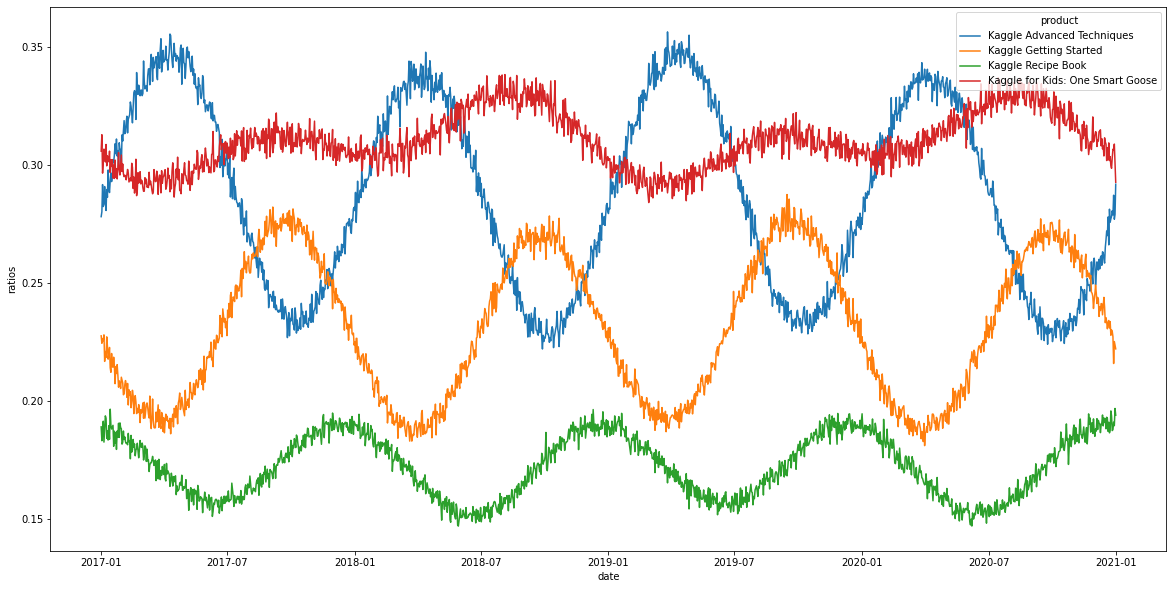

In [17]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product")
#wandb.log({"procuct_ratios": wandb.Image(f)})

**Analyse frequency spectrum**
- Adapted from [Stack Overflow](https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy) by [unsym](https://stackoverflow.com/users/535615/unsym) 

In [16]:
def fit_sin(tt, yy, contains_addition=False):
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
        Contains addition is only for the "Kaggle for Kids: One Smart Goose" product
    '''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1]-tt[0]))   # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    guess_freq = abs(ff[np.argmax(Fyy[1:])+1])   # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array([guess_amp, 2.*np.pi*guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c):  return A * np.sin(w*t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt
    f = w/(2.*np.pi)
    if contains_addition:
      fitfunc = lambda t: (A * np.sin(w*t + p) + A * np.sin(w/2*t + p)) + c
    else:
      fitfunc = lambda t: A * np.sin(w*t + p) + c
    return {"amp": A, "omega": w, "phase": p, "offset": c, "freq": f, "period": 1./f, "fitfunc": fitfunc, "maxcov": np.max(pcov), "rawres": (guess,popt,pcov)}

In [17]:
import pylab as plt
def get_fitted_function(product_ratio_df, product_name):

  prod = np.array(product_ratio_df[product_ratio_df['product'] == product_name]["ratios"])

  DAYS_PER_YEAR = 365
  N = DAYS_PER_YEAR * 4

  tt = np.linspace(0, 4, N)

  # Calculate for one year longer (=test set)
  tt2 = np.linspace(0, 5, N + 365)

  if product_name == "Kaggle for Kids: One Smart Goose":
    res = fit_sin(tt, prod, contains_addition=True)
  else:
    res = fit_sin(tt, prod, contains_addition=False)
  
  print( "Amplitude=%(amp)s, Angular freq.=%(omega)s, phase=%(phase)s, offset=%(offset)s, Max. Cov.=%(maxcov)s" % res )

  plt.plot(tt, prod, "ok", label="y with noise")
  plt.plot(tt2, res["fitfunc"](tt2), "r-", label="y fit curve", linewidth=2)
  plt.legend(loc="best")
  plt.show()
  return res["fitfunc"](tt2)

Amplitude=0.0555102480970908, Angular freq.=6.295751842911955, phase=-0.14258088945642614, offset=0.2872635539595127, Max. Cov.=4.818887478596677e-05


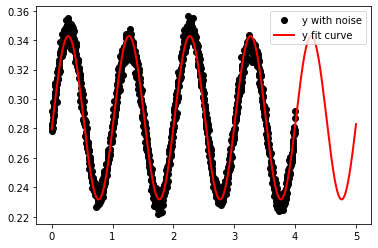

Amplitude=-0.041626160345494316, Angular freq.=6.2729779997818795, phase=0.12193375549750761, offset=0.23076782996876932, Max. Cov.=5.771555584768186e-05


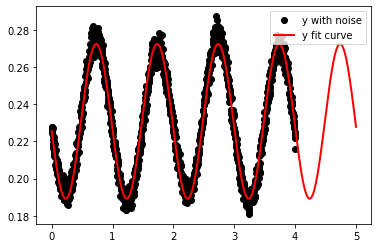

Amplitude=0.017758848686809794, Angular freq.=6.286066890579836, phase=1.8373782165406856, offset=0.1720750343136213, Max. Cov.=0.00018830469504297197


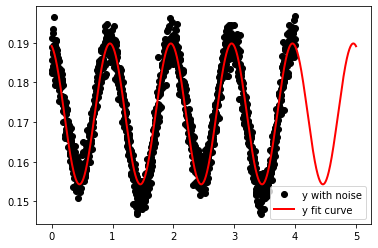

Amplitude=-0.011106105842878165, Angular freq.=6.423819298717819, phase=0.3255392017314274, offset=0.310028387786753, Max. Cov.=0.0032917404575968953


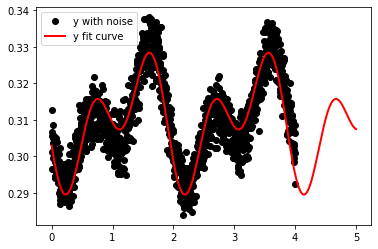

In [18]:
prod_to_pred = {}
for product in product_ratio_df["product"].unique():
  pred = get_fitted_function(product_ratio_df, product)
  prod_to_pred[product] = pred


- **Note**: A flag `contains_addition` was introduced to adapt the `fitfunc` for the last product as here two sine functions are added.
- This is visualised in the following frequency spectrum plot where for the product `Kallge for Kids: One Smart Goose` there are two frequencies of same Amplitude in the signal. Therefore use the following function.
```fitfunc = lambda t: (A * numpy.sin(w*t + p) + A * numpy.sin(w/2*t + p)) + c```

In [19]:
prod_1_ratio = np.array(product_ratio_df[product_ratio_df['product'] == "Kaggle for Kids: One Smart Goose"]["ratios"])

Max value is 0.3381400824014126 - Min value is 0.2839279568658942 
Max freuqency at : 0.25


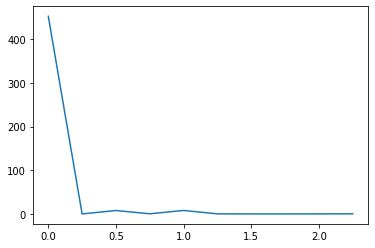

In [20]:
from scipy.fft import fft, fftfreq
SAMPLE_RATE = 365 # Days per year
DURATION = 4      # years
N = SAMPLE_RATE * DURATION

print(f"Max value is {np.max(prod_1_ratio)} - Min value is {np.min(prod_1_ratio)} ")
yf = fft(prod_1_ratio)
xf = fftfreq(N, 1 / SAMPLE_RATE)

print(f"Max freuqency at : {xf[np.argmax(np.abs(yf)) + 1]}")

plt.plot(xf[:10], np.abs(yf[:10]))
plt.show()

**Result**: 
- Frequency of 0.5 (2 years period) and 1 (1 year period) is included in the signal.



**Insight**

As we have a clear seasonal pattern of the ratio of sales for each product, we do not need to forecast each product individually (or treat product as a categorical variable etc.). Instead we can forecast the sum of all sales each day, then afterwards convert the forecasted sum down to the forecast for each product, using the forecasted **ratios** for each date.

**Conclusions** 

All this together means we only need to forecast 2 time series:
1. The total sales each day
2. The ratio in number of sales for each product each day

Once we have completed the forecasts we can break the forecast down into the 3 categorical variables: Product, Country and Store.

### **Prepare the dataset**
- Inspired by the official [Tensorflow guide](https://www.tensorflow.org/tutorials/structured_data/time_series)

### 💡 **Steps to take**: 
- **How to handle the country feature**: After 2020 the country does not influence the sales. It is assumed that this will continue to be a trend in 2021. Therefore the country will be ignored.
- **How to handle the store feature**: From EDA we know that `KaggleMart` makes up `0.742515` and `KaggleRama` makes up `0.257485` of total sales. After predicting the absolute sales we can then disaggregate by using these ratios.
- **Predict sales**: Sum up the number of sales over all features, clean data, add time information, seperate the data into windows and try different architectures such as LSTM, DNN.
- **Predict ratios**: 
    - **Fourier**: Try to find frequency using Fourier.
    - **Predict**: Or try using a simple model such as an XGBoost.
- **Predict test data**: Disaggregate total sales forecast using the predicted ratios.

**Add weekly and yearly seasonality information**

In [381]:
ROWS_PER_DAY  = 4 * 2 * 6
DAYS_PER_WEEK = 7
# Leap year day will be ignored as we only predict data for 2021
DAYS_PER_YEAR = 365 

In [382]:
def add_seasonality_information(train_df, test_df):
    # Note: As weeks don't end after 1 year it is important to count the day indices from the 
    # beginning of the train all the way to the end of the test set.
    day_indices = np.array([i // ROWS_PER_DAY for i in range(0, len(train_df) + len(test_df))])
    # Seperate indices
    day_indices_train = day_indices[:len(train_df)]
    day_indices_test = day_indices[len(train_df):]

    #day_indices_test = np.array([i // ROWS_PER_DAY for i in range(0, len(test_df))])
    assert len(day_indices_train) == train_df.shape[0]
    assert len(day_indices_test) == test_df.shape[0]
    # Add seasonality information as sine & cosine to train & test dataset
    # Note: Substract 1 as we start counting from 0
    train_df['week_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
    train_df['week_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_WEEK - 1)))
    train_df['year_sin'] = np.sin(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))
    train_df['year_cos'] = np.cos(day_indices_train * (2 * np.pi / (DAYS_PER_YEAR - 1)))

    test_df['week_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
    test_df['week_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_WEEK - 1)))
    test_df['year_sin'] = np.sin(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))
    test_df['year_cos'] = np.cos(day_indices_test * (2 * np.pi / (DAYS_PER_YEAR - 1)))
    return train_df, test_df

In [383]:
train_df, test_df = add_seasonality_information(train_df, test_df)

<b> Note: </b> 
- It is clear that the indices are correct as the week cycle continues in the test set

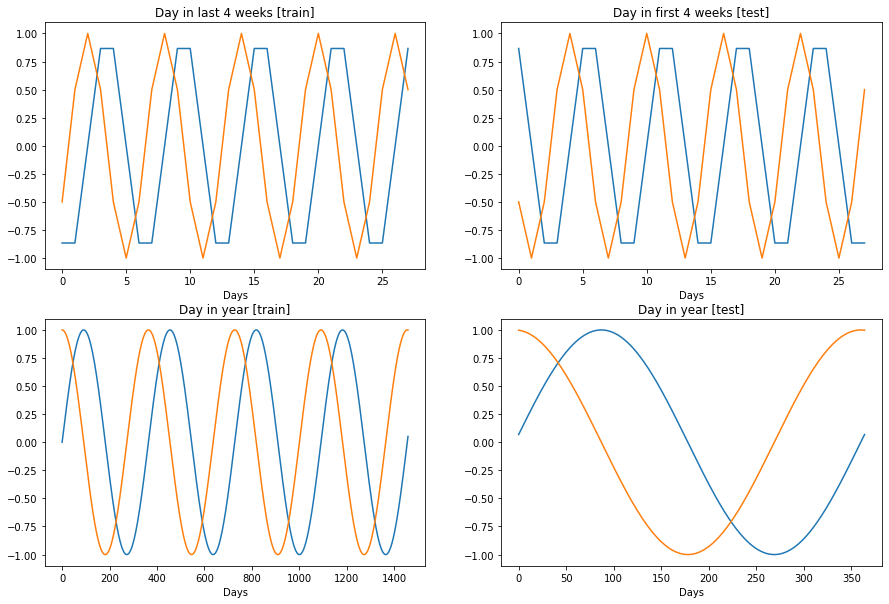

In [384]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axes[0][0].set_title('Day in last 4 weeks [train]')
axes[0][0].set_xlabel('Days')
axes[0][0].plot(np.array(train_df['week_sin'])[::ROWS_PER_DAY][-28:])
axes[0][0].plot(np.array(train_df['week_cos'])[::ROWS_PER_DAY][-28:])
axes[0][1].set_title('Day in first 4 weeks [test]')
axes[0][1].set_xlabel('Days')
axes[0][1].plot(np.array(test_df['week_sin'])[::ROWS_PER_DAY][:28])
axes[0][1].plot(np.array(test_df['week_cos'])[::ROWS_PER_DAY][:28])
axes[1][0].set_title('Day in year [train]')
axes[1][0].set_xlabel('Days')
axes[1][0].plot(np.array(train_df['year_sin'])[::ROWS_PER_DAY])
axes[1][0].plot(np.array(train_df['year_cos'])[::ROWS_PER_DAY])
axes[1][1].set_title('Day in year [test]')
axes[1][1].set_xlabel('Days')
axes[1][1].plot(np.array(test_df['year_sin'])[::ROWS_PER_DAY])
axes[1][1].plot(np.array(test_df['year_cos'])[::ROWS_PER_DAY])

**Calculate absolute sales**

In [573]:
train_total_sales_df = train_df.groupby(['date']).agg({
    'num_sold': 'sum',
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

In [574]:
test_total_sales_df = test_df.groupby(['date']).agg({
    'year_cos': 'first',
    'year_sin': 'first',
    'week_sin': 'first',
    'week_cos': 'first',
}).reset_index()

**Get all dates**: Useful lateron

In [575]:
dates_df = pd.concat([train_total_sales_df["date"], test_total_sales_df["date"]], ignore_index=True).reset_index().drop(["index"], axis=1)
dates_df.tail()

date
1820 2021-12-27
1821 2021-12-28
1822 2021-12-29
1823 2021-12-30
1824 2021-12-31

**Normalise and split data**

In [576]:
# Store for later
total_sales_mean = train_total_sales_df.num_sold.mean()
total_sales_std = train_total_sales_df.num_sold.std()

# Standardize
train_total_sales_df["num_sold"] = (train_total_sales_df["num_sold"] - total_sales_mean) / total_sales_std

In [577]:
val_total_sales_df = train_total_sales_df[train_total_sales_df["date"] > pd.Timestamp("2020-10-01")]
#train_total_sales_df = train_total_sales_df[train_total_sales_df["date"] <= pd.Timestamp("2020-10-01")]

**Remove outliers**
- Data from beginning of January 2020 to May is irregular

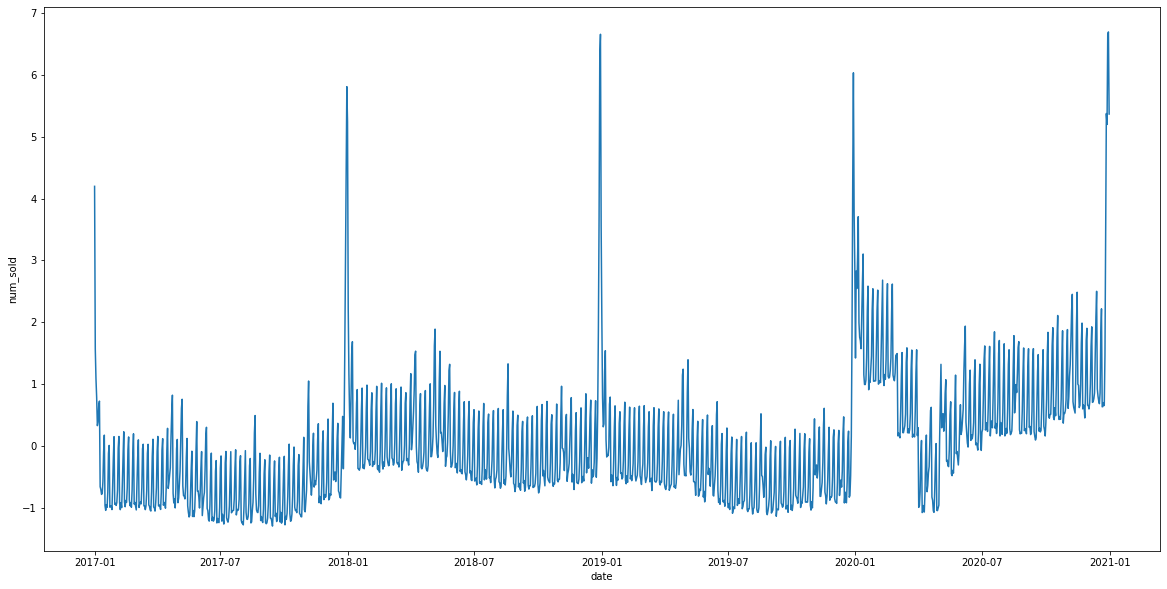

In [578]:
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = train_total_sales_df, x="date", y="num_sold");

In [579]:
# Split into two frames as we will window the dataset afterward and
# this windowing could lead to confusion
train_total_sales_df_before = train_total_sales_df.loc[train_total_sales_df["date"] < "2020-01-02" ]
train_total_sales_df_after = train_total_sales_df.loc[train_total_sales_df["date"] >= "2020-05-01"]

**Set date as index**

In [580]:
train_total_sales_df.set_index("date", inplace=True)
train_total_sales_df_before.set_index("date", inplace=True)
train_total_sales_df_after.set_index("date", inplace=True)
val_total_sales_df.set_index("date", inplace=True)
test_total_sales_df.set_index("date", inplace=True)

### Prepare ratios dataframe

In [581]:
pred_ratios_df = dates_df.copy(deep=True)

In [582]:
for prod in prod_to_pred:
  product_ratios = prod_to_pred[prod]
  pred_ratios_df[prod] = product_ratios

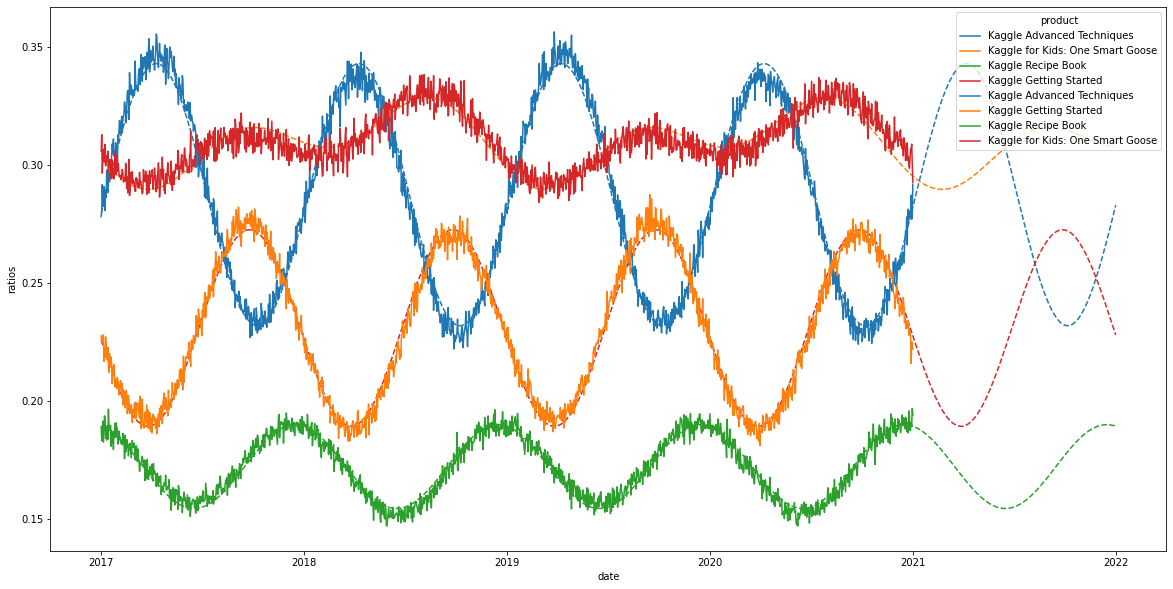

In [583]:
pred_ratios_df = pred_ratios_df.melt(var_name='product', value_name='ratios', id_vars=['date']).sort_values("date").reset_index(drop=True)
f,ax = plt.subplots(figsize=(20,10))
sns.lineplot(data = pred_ratios_df, x="date", y="ratios", hue="product", linestyle='--')
sns.lineplot(data = product_ratio_df, x="date", y="ratios", hue="product")

### Create a Window Generator
- Source is [the official TF tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)

In [584]:
# Util to set and reset the date columns as index
def reset_date_index(df):
  if df.index.name == 'date':
    df.reset_index(inplace=True)
  return df 

def set_date_index(df):
  if df.index.name != 'date':
    df.set_index('date', inplace=True)
  return df

In [585]:
# Important to keep the column order constant when performing manual inference lateron!
COLUMN_ORDER =  train_total_sales_df.columns
print(f"The column order is : {COLUMN_ORDER}")
def reindex_dataframe(df):
  # Sets index otherwise date will be lost
  df = set_date_index(df)
  df = df.reindex(columns=COLUMN_ORDER)
  return df

The column order is : Index(['num_sold', 'year_cos', 'year_sin', 'week_sin', 'week_cos'], dtype='object')


In [586]:
# Reindex the datasets
train_total_sales_df = reindex_dataframe(train_total_sales_df)
train_total_sales_df_before = reindex_dataframe(train_total_sales_df_before)
train_total_sales_df_after = reindex_dataframe(train_total_sales_df_after)
val_total_sales_df = reindex_dataframe(val_total_sales_df)

In [587]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_total_sales_df = train_total_sales_df,
               train_df_before_outlier = train_total_sales_df_before, 
               train_df_after_outlier = train_total_sales_df_after,
               val_df=val_total_sales_df, 
               label_columns=None):
    
    # Store the raw data.
    self.train_df = set_date_index(train_total_sales_df)
    self.train_df_before_outlier = set_date_index(train_df_before_outlier)
    self.train_df_after_outlier = set_date_index(train_df_after_outlier)
    self.val_df = set_date_index(val_df)

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(self.train_df.columns)}
    print(self.label_columns_indices)
    print(self.column_indices)
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    # e.g. [0,1,...,27]
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    # e.g. [1,2,...,28]
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  @property
  def train(self):
    ds_1 = self.make_dataset(set_date_index(self.train_df_before_outlier))
    ds_2 = self.make_dataset(set_date_index(self.train_df_after_outlier))
    return ds_1.concatenate(ds_2)
    #return self.make_dataset(set_date_index(self.train_df))

  @property
  def val(self):
    return self.make_dataset(set_date_index(self.val_df))

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

  def split_window(self, features):
    """ Split features into the actual inputs and labels. 

      E.g. features shape (batch, timesteps = total_window_size, features)
    """
    # Split input with timesteps = total_window_size into inputs and labels
    # by using their indices
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    # Only use the target columns as labels
    if self.label_columns is not None:
      # !!Right here it is essential to have the correct order !!
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns],
          axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='num_sold', max_subplots=3):
    """ Plot predictions or example for one target column"""
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index],
              label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index],
                  edgecolors='k', label='Labels', c='#2ca02c', s=64)
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Days')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    # Output is a dataset with batches of sequences
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=False,
        batch_size=32,)
    ds = ds.map(self.split_window)

    return ds


  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [588]:
w2 = WindowGenerator(input_width=14, 
                     label_width=14, 
                     shift=1, 
                     label_columns=["num_sold"])


# Example input to split_window = output from tf.keras.utils.timeseries_dataset_from_array()
# Here: 3 batches with 14 timestamps and all features
example_window = tf.stack([np.array(train_total_sales_df[:w2.total_window_size]),
                          np.array(train_total_sales_df[100:100+w2.total_window_size])])
example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

{'num_sold': 0}
{'num_sold': 0, 'year_cos': 1, 'year_sin': 2, 'week_sin': 3, 'week_cos': 4}
All shapes are: (batch, time, features)
Window shape: (2, 15, 5)
Inputs shape: (2, 14, 5)
Labels shape: (2, 14, 1)


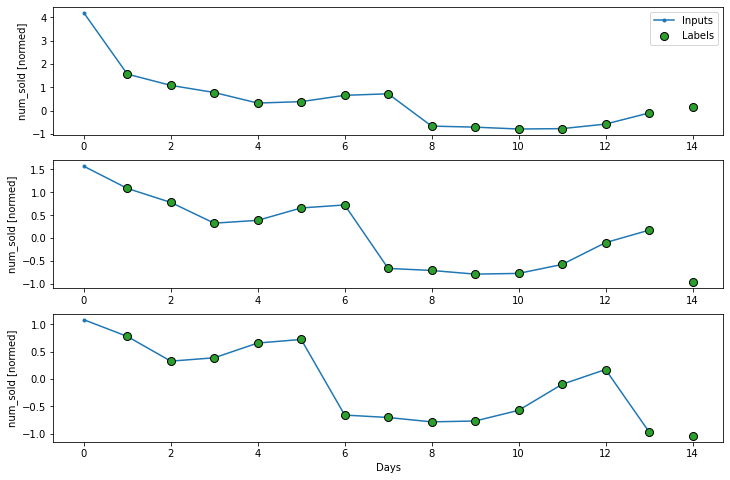

In [589]:
w2.plot()

In [590]:
# One element in the training dataset
w2.train.element_spec

(TensorSpec(shape=(None, 14, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 14, 1), dtype=tf.float32, name=None))

In [591]:
# Iterating yields batches
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 14, 5)
Labels shape (batch, time, features): (32, 14, 1)


### Util functions

In [592]:
def compile_and_fit(model, window, patience=4, epochs=20):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, validation_data=window.val, epochs=epochs, callbacks=[early_stopping])
  return history

In [593]:
def run_inference(test_df_prep, train_df_prep, model, input_width, label, expand_dim = False):
  """ Runs inference on test dataset 

      test_df_prep:   Prepared test dataframe
      train_df_prep:  Prepared train dataframe
      model:          Model to use for inference
      input_width:    Width of input per inference (e.g. 14 samples)
      label:          Label of target columns
  """
  # Model to use
  model = model
  # Copy test_df to allow multiple inferences
  test_df = test_df_prep.copy(deep=True)

  train_df_prep = reindex_dataframe(train_df_prep)
  print(f"Reference dataframe columns {train_df_prep.columns}")
  # Add target columns to test data
  test_df[label] = np.nan
  test_df = reindex_dataframe(test_df)
  print(f"To be filled dataframe columns {test_df.columns}")
  
  label_idx = test_df.columns.get_loc(label)
  print(f"Label index: {label_idx}")
  # Predict the individual days
  for test_idx in range(len(test_df)):
    # E.g. 14 inputs to predict model output. If test_idx = 0 -> 14 samples from train data
    train_data_samples = input_width - test_idx
    if train_data_samples > 0:
      train_data = train_df_prep.iloc[-train_data_samples:,:]
      test_data = test_df.iloc[:test_idx,:]
      inference_data = pd.concat([train_data,test_data])
    else:
      inference_data = test_df.iloc[test_idx-INPUT_WIDTH:test_idx,:]
    # Run inference
    if expand_dim:
      input = np.array(inference_data, dtype=np.float32)
      input = input.reshape(1, input.shape[0], input.shape[1])
      pred = model(input)
      # Add predicted values to the test dataframe
      test_df.iloc[test_idx,label_idx] = pred[0][-1].numpy()
    else:
      pred = model(np.array(inference_data, dtype=np.float32))
      # Add predicted values to the test dataframe
      test_df.iloc[test_idx,label_idx] = pred[-1].numpy()

  return test_df

In [594]:
def plot_predictions(val_predictions, test_predictions):
  """Plot validation and test set predictions in one plot with the train data"""
  reset_date_index(train_total_sales_df)
  reset_date_index(val_predictions)
  reset_date_index(test_predictions)

  plot_total_sales_df = pd.concat([train_total_sales_df, val_predictions,test_predictions])
  plot_total_sales_df.reset_index(inplace=True, drop=True)
  f,ax = plt.subplots(figsize=(20,10))
  sns.lineplot(data=plot_total_sales_df, x="date", y="num_sold");

In [595]:
def get_model_predictions(current_model, expand_dim=True):
  """ Run inference for both validation and test set """
  # Set date index if not set yet
  set_date_index(val_total_sales_df)
  set_date_index(train_total_sales_df)
  # Run inference on val data
  val_predictions = run_inference(val_total_sales_df, 
                                  train_total_sales_df, 
                                  current_model, 
                                  INPUT_WIDTH, 
                                  LABEL_COLUMN_NAMES[0], 
                                  expand_dim=expand_dim)
  val_predictions.reset_index(inplace=True)

  # Set date index if not set yet
  set_date_index(test_total_sales_df)
  set_date_index(val_total_sales_df)
  # Run inference on test data
  test_predictions = run_inference(test_total_sales_df, 
                                  val_total_sales_df, 
                                  current_model, 
                                  INPUT_WIDTH, 
                                  LABEL_COLUMN_NAMES[0], 
                                  expand_dim=expand_dim)
  test_predictions.reset_index(inplace=True)
  return val_predictions, test_predictions

In [596]:
INPUT_WIDTH = 28
LABEL_WIDTH = 28
SHIFT = 1
LABEL_COLUMN_NAMES =["num_sold"]

In [597]:
window = WindowGenerator(input_width=INPUT_WIDTH, 
                     label_width=LABEL_WIDTH, 
                     shift=SHIFT,
                     label_columns=LABEL_COLUMN_NAMES)
window.train.element_spec

{'num_sold': 0}
{'num_sold': 0, 'year_cos': 1, 'year_sin': 2, 'week_sin': 3, 'week_cos': 4}


(TensorSpec(shape=(None, 28, 5), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 28, 1), dtype=tf.float32, name=None))

## Train models

### 1.) Baseline model
```
linear baseline score: 30.24190
```

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=4)
])

### 2.) Dense model

In [598]:
dense = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=265, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=265, activation='relu'),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
current_model = dense

### 3.) LSTM model

In [514]:
lstm = tf.keras.Sequential([
  tf.keras.layers.LSTM(265, return_sequences=True),
  tf.keras.layers.LSTM(265, return_sequences=True),
  tf.keras.layers.Dense(512),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(1),
])
current_model = lstm

In [599]:
history = compile_and_fit(current_model, window, epochs=100)

Epoch 1/500
41/41 [==============================] - 2s 24ms/step - loss: 0.7333 - mean_absolute_error: 0.6280 - val_loss: 2.1771 - val_mean_absolute_error: 1.2676
Epoch 2/500
41/41 [==============================] - 1s 23ms/step - loss: 0.6973 - mean_absolute_error: 0.6151 - val_loss: 2.0037 - val_mean_absolute_error: 1.1990
Epoch 3/500
41/41 [==============================] - 1s 30ms/step - loss: 0.6765 - mean_absolute_error: 0.6087 - val_loss: 1.8662 - val_mean_absolute_error: 1.1416
Epoch 4/500
41/41 [==============================] - 1s 20ms/step - loss: 0.6556 - mean_absolute_error: 0.6004 - val_loss: 1.7431 - val_mean_absolute_error: 1.0875
Epoch 5/500
41/41 [==============================] - 1s 19ms/step - loss: 0.6335 - mean_absolute_error: 0.5903 - val_loss: 1.6230 - val_mean_absolute_error: 1.0318
Epoch 6/500
41/41 [==============================] - 1s 20ms/step - loss: 0.6099 - mean_absolute_error: 0.5784 - val_loss: 1.5010 - val_mean_absolute_error: 0.9716
Epoch 7/500
41/4

Reference dataframe columns Index(['num_sold', 'year_cos', 'year_sin', 'week_sin', 'week_cos'], dtype='object')
To be filled dataframe columns Index(['num_sold', 'year_cos', 'year_sin', 'week_sin', 'week_cos'], dtype='object')
Label index: 0
Reference dataframe columns Index(['num_sold', 'year_cos', 'year_sin', 'week_sin', 'week_cos'], dtype='object')
To be filled dataframe columns Index(['num_sold', 'year_cos', 'year_sin', 'week_sin', 'week_cos'], dtype='object')
Label index: 0


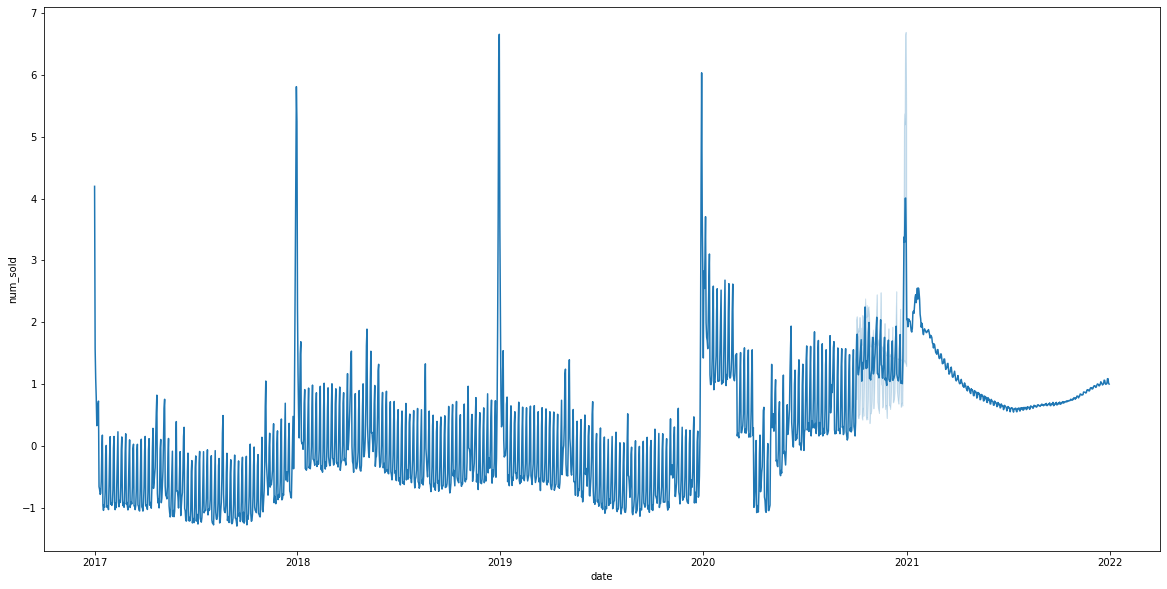

In [608]:
val_predictions, test_predictions = get_model_predictions(current_model, expand_dim=True)
plot_predictions(val_predictions, test_predictions)

### Try performance with XGBoost

In [660]:
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=800, max_depth=4)

In [661]:
y = train_total_sales_df["num_sold"]
X = train_total_sales_df.drop(columns="num_sold")
X.drop("date", inplace=True, axis=1)
test_total_sales_df_pred = test_total_sales_df.copy(deep=True)
X_test = test_total_sales_df

In [662]:
model.fit(X,y)

[20:22:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=4, n_estimators=800)

In [663]:
preds = model.predict(X_test)
test_total_sales_df_pred["num_sold"] = preds

In [664]:
test_total_sales_df_pred.reset_index(inplace=True)

In [665]:
test_total_sales_df_pred.head()

date  year_cos  year_sin      week_sin  week_cos  num_sold
0 2021-01-01  0.997617  0.068991  8.660254e-01      -0.5  0.350248
1 2021-01-02  0.996278  0.086200  1.342473e-13      -1.0  0.080868
2 2021-01-03  0.994642  0.103384 -8.660254e-01      -0.5  1.540534
3 2021-01-04  0.992709  0.120537 -8.660254e-01       0.5  1.711086
4 2021-01-05  0.990480  0.137654 -2.587147e-13       1.0  1.984218

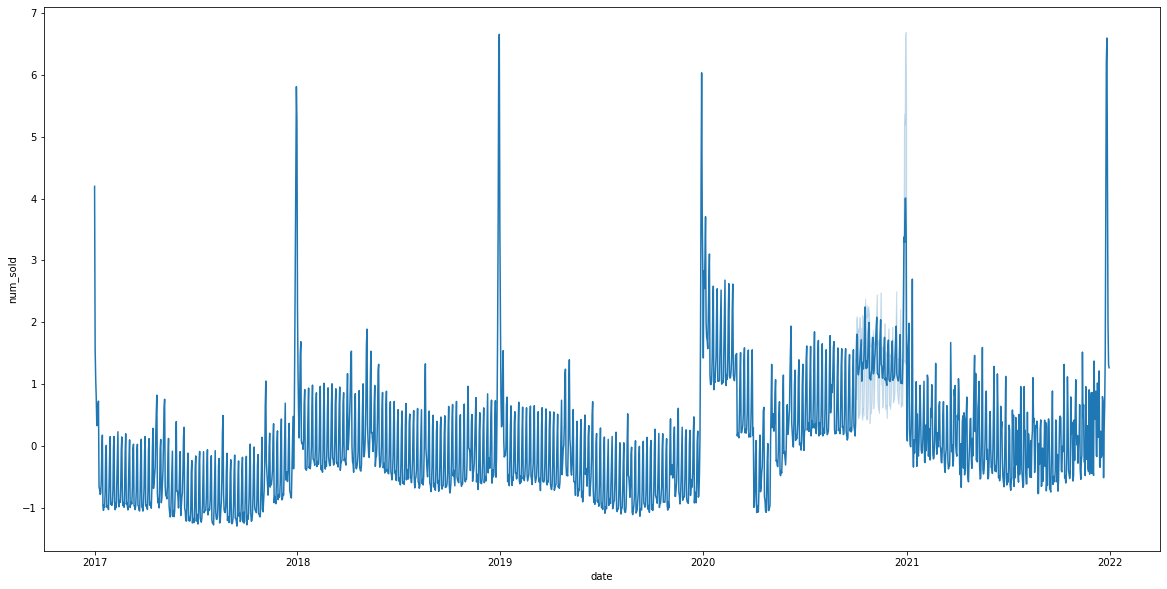

In [666]:
plot_predictions(val_predictions, test_total_sales_df_pred[["date", "num_sold"]])

### Disaggregate predictions

In [667]:
def disaggregate(df):# Columns are not needed, only `num_sales` matters.
  df = df.drop(["year_cos", "year_sin", "week_cos", "week_sin"], axis=1)
  test_pred_df = test_df.merge(df, on='date', how='left')
  test_pred_df = test_pred_df.merge(pred_ratios_df, on=['date', 'product'], how='left')
  test_pred_df["num_sold"] = (test_pred_df["num_sold"] * total_sales_std) + total_sales_mean
  test_pred_df["country_weight"] = 1/6
  test_pred_df.loc[test_pred_df["store"] == "KaggleMart","store_weight"] = 0.742515
  test_pred_df.loc[test_pred_df["store"] == "KaggleRama","store_weight"] = 0.257485
  test_pred_df['num_sold'] = test_pred_df["num_sold"] * test_pred_df["ratios"] * test_pred_df["country_weight"] * test_pred_df["store_weight"]
  return test_pred_df

In [668]:
final_df = disaggregate(set_date_index(test_total_sales_df_pred))

In [669]:
final_df.head()

row_id       date  country       store                           product  \
0   70128 2021-01-01  Belgium  KaggleMart        Kaggle Advanced Techniques   
1   70129 2021-01-01  Belgium  KaggleMart            Kaggle Getting Started   
2   70130 2021-01-01  Belgium  KaggleMart                Kaggle Recipe Book   
3   70131 2021-01-01  Belgium  KaggleMart  Kaggle for Kids: One Smart Goose   
4   70132 2021-01-01  Belgium  KaggleRama        Kaggle Advanced Techniques   

   week_sin  week_cos  year_sin  year_cos    num_sold    ratios  \
0  0.866025      -0.5  0.068991  0.997617  344.040985  0.282910   
1  0.866025      -0.5  0.068991  0.997617  275.837223  0.226825   
2  0.866025      -0.5  0.068991  0.997617  229.939534  0.189083   
3  0.866025      -0.5  0.068991  0.997617  358.641740  0.294916   
4  0.866025      -0.5  0.068991  0.997617  119.304517  0.282910   

   country_weight  store_weight  
0        0.166667      0.742515  
1        0.166667      0.742515  
2        0.166667      0.742515  
3        0.166667      0.742515  
4        0.166667      0.257485

### Plot result

In [656]:
def plot_all(df):
    f,axes = plt.subplots(2,2,figsize=(20,15), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))

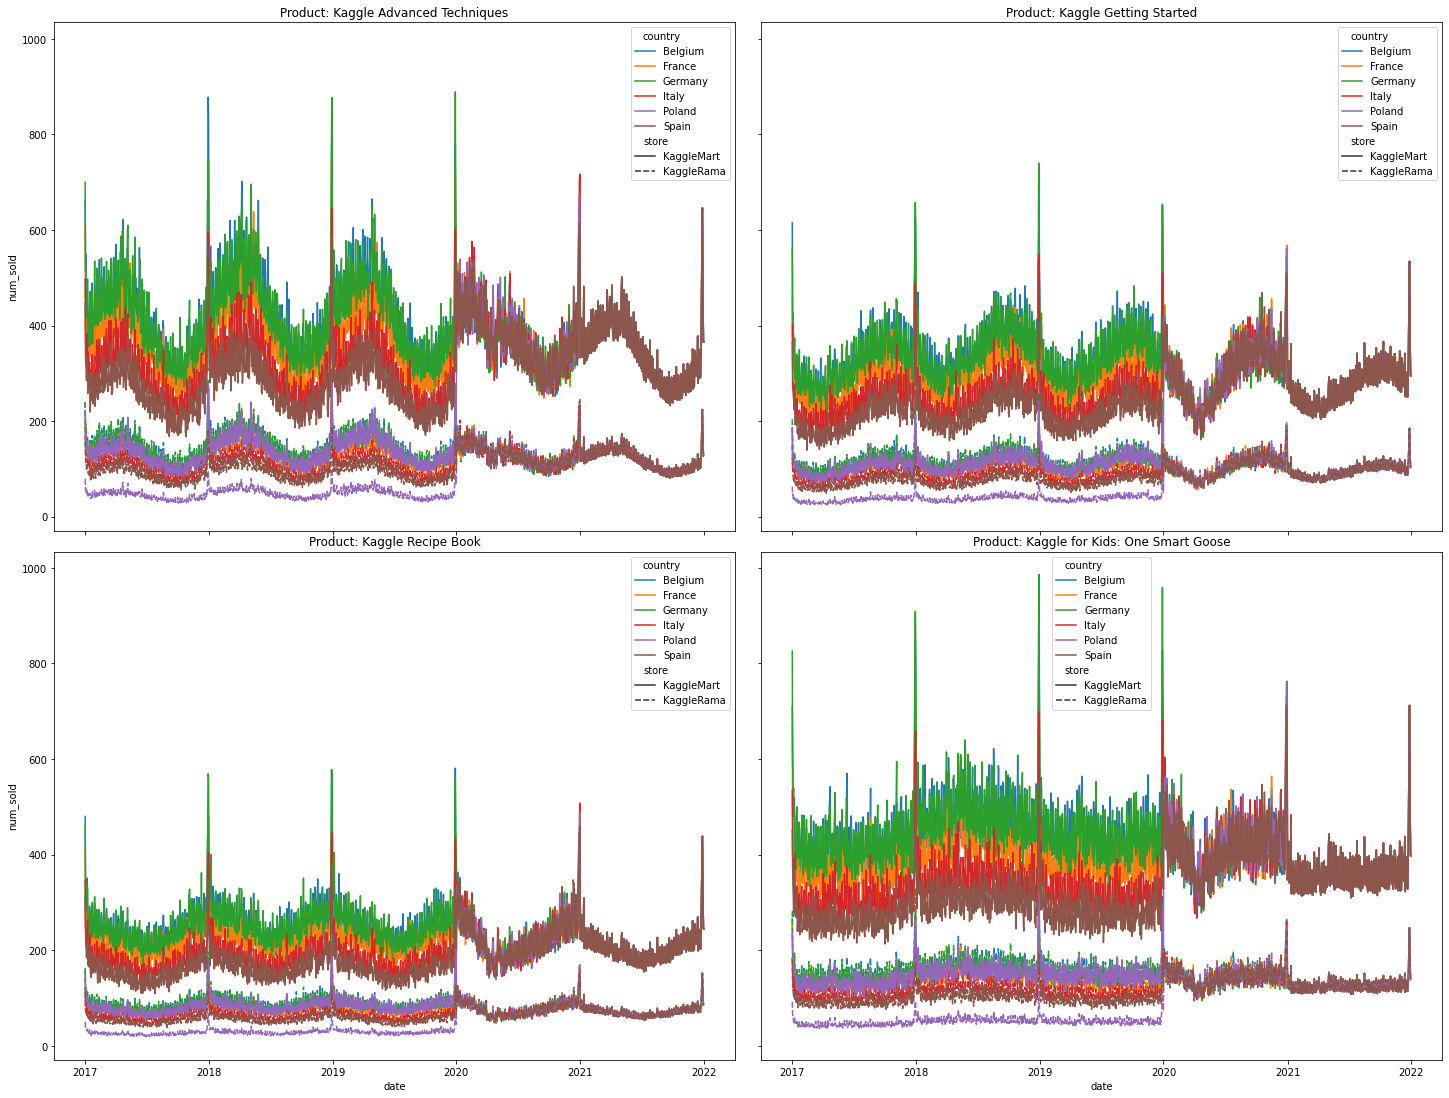

In [658]:
plot_all(pd.concat([train_df,final_df]).reset_index(drop=True))

### Convert to submission format

In [659]:
result_df = final_df[["row_id","num_sold"]]
result_df['num_sold'] = result_df['num_sold'].astype('int')
result_df.to_csv(os.path.join(".", "submissions", "xgboost.csv"), index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Final thoughts
- **Architecture**: Using complicated LSTM or DNN leads to the best score of ~9 which is quite bad in comparison to the leaderboard results. The proglem here seems to be that the model does not learn to include the large sinusoidal weekly cycles. Just throwing a complex model at a problem does not solve it.
- **Features**: Training an XGBoost Regressor on the dataset results in an even worse score of ~15. It can therefore be concluded that the feature representation of time as employed in this Notebook does not allow the model to fully understand the context.